In [8]:
import pandas as pd
import numpy as np

import tubesml as tml

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


import lightgbm as lgb

from sklearn.pipeline import Pipeline

from src.model_validation import TSCrossValidate, summary_evaluation, fold_evaluation
from src.model_helpers import DailyModel, ColumnSelector
from src.sharpe import score_sharpe
from src.features import FeatureEng

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [9]:
df = pd.read_csv("data_raw/train.csv")

df = df[df["date_id"] > 1000].copy()
df.head()

date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  E1  E10  E11  E12  E13  \
1001     1001   0   0   0   1   0   0   0   0   0 NaN  NaN  NaN  NaN  NaN   
1002     1002   0   0   0   1   0   0   0   0   0 NaN  NaN  NaN  NaN  NaN   
1003     1003   0   0   0   1   0   0   0   0   0 NaN  NaN  NaN  NaN  NaN   
1004     1004   1   1   0   1   0   0   0   0   0 NaN  NaN  NaN  NaN  NaN   
1005     1005   0   0   0   1   0  -1   0   0   0 NaN  NaN  NaN  NaN  NaN   

      E14  E15  E16  E17  E18  E19  E2  E20  E3  E4  E5  E6  E7  E8  E9  I1  \
1001  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1002  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1003  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1004  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1005  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   

      I2  I3  I4  I5  I6  I7  I8  I9  M1  M10  M11  M12  M13  M14  M15  M16  \
1001 NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1002 NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1003 NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1004 NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1005 NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

      M17  M18  M2  M3  M4  M5  M6  M7  M8  M9  P1  P10  P11  P12  P13  P2  \
1001  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN NaN   
1002  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN NaN   
1003  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN NaN   
1004  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN NaN   
1005  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN NaN   

      P3  P4  P5  P6  P7  P8  P9  S1  S10  S11  S12  S2  S3  S4  S5  S6  S7  \
1001 NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN   
1002 NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN   
1003 NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN   
1004 NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN   
1005 NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN   

      S8  S9  V1  V10  V11  V12  V13  V2  V3  V4  V5  V6  V7  V8  V9  \
1001 NaN NaN NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1002 NaN NaN NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1003 NaN NaN NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1004 NaN NaN NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1005 NaN NaN NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   

      forward_returns  risk_free_rate  market_forward_excess_returns  
1001         0.003361        0.000120                       0.002932  
1002         0.005496        0.000120                       0.005066  
1003         0.001342        0.000120                       0.000912  
1004        -0.003350        0.000121                      -0.003781  
1005         0.006725        0.000122                       0.006293

In [10]:
TARGET = "market_forward_excess_returns"
DROP = ['is_scored', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
FEATURES = [c for c in df.columns if c not in DROP]

In [11]:
ts_folds = TimeSeriesSplit(n_splits=10, test_size=180)

In [ ]:
def add_streak_features(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Add rolling features counting consecutive positive/negative streaks.
    
    Args:
        df: DataFrame with the column to analyze
        column: Name of the column to track streaks for
    
    Returns:
        DataFrame with added streak columns
    """
    df = df.copy()

    df["temp_col"] = df[column].shift()
    
    # Create binary indicators for positive/negative
    df['_is_positive'] = (df["temp_col"] > 0).astype(int)
    df['_is_negative'] = (df["temp_col"] < 0).astype(int)
    
    # Create streak groups (changes when sign changes)
    df['_pos_streak_group'] = (df['_is_positive'] != df['_is_positive'].shift()).cumsum()
    df['_neg_streak_group'] = (df['_is_negative'] != df['_is_negative'].shift()).cumsum()
    
    # Count consecutive occurrences within each group
    df[f'{column}_positive_streak'] = df.groupby('_pos_streak_group')['_is_positive'].cumsum() * df['_is_positive']
    df[f'{column}_negative_streak'] = df.groupby('_neg_streak_group')['_is_negative'].cumsum() * df['_is_negative']
    
    # Clean up temporary columns
    df = df.drop(columns=['_is_positive', '_is_negative', '_pos_streak_group', '_neg_streak_group', "temp_col"])
    
    return df


def make_lags_train(data):
    df = data.copy()

    targets = ['forward_returns', 'risk_free_rate']

    for col in targets:
        for lag in [1, 5, 22]:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
        
        for w in [5, 22, 220]:
            df[f"{col}_mean_{w}"] = df[col].shift(1).rolling(w, min_periods=w).mean()
            df[f"{col}_std_{w}"] = df[col].shift(1).rolling(w, min_periods=w).std()

        if col == "forward_returns":
            df = add_streak_features(df, col)

    return df

[2, 166, 1, 241, 309, 46, 1, 2892, 1, 1]
Mean Squared Error: 0.00012
R2: 0.0012482115584687703
MAE: 0.007917397636121403
               min      mean       max
fold                                  
0     3.170950e-12  0.000110  0.001542
1     1.376493e-10  0.000061  0.000921
2     1.777117e-10  0.000322  0.001629
3     1.995839e-12  0.000078  0.001198
4     3.570748e-09  0.000102  0.000885
5     4.384872e-10  0.000246  0.001646
6     5.401464e-09  0.000078  0.000626
7     2.519868e-09  0.000054  0.000410
8     1.202802e-10  0.000069  0.000925
9     2.321015e-10  0.000117  0.001656
Sharpe: 0.682367097619905
0 -0.22740535824023056
1 1.963383201305177
2 0.6173130477045005
3 2.082854558505653
4 0.40989838505826826
5 -0.7543727168267673
6 0.9685449644742558
7 2.0776876345188646
8 1.0526303038858706
9 0.6011036744965932


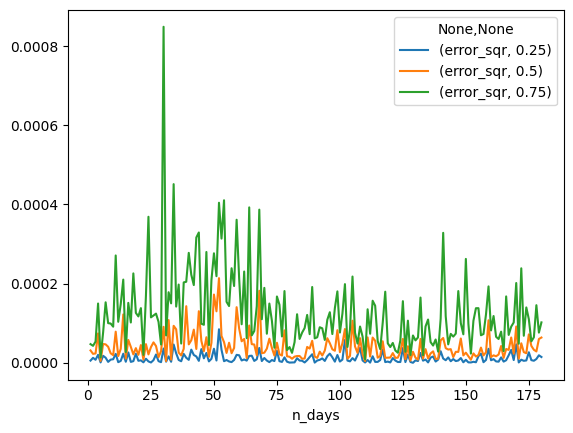

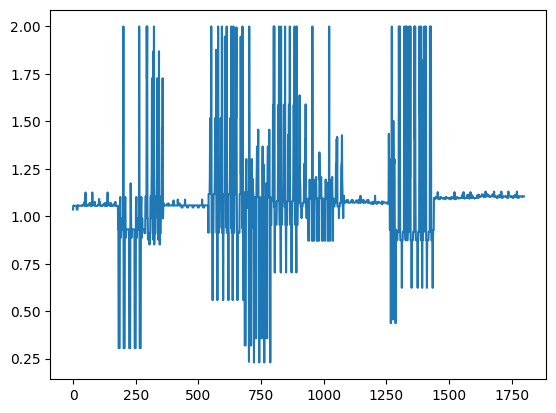

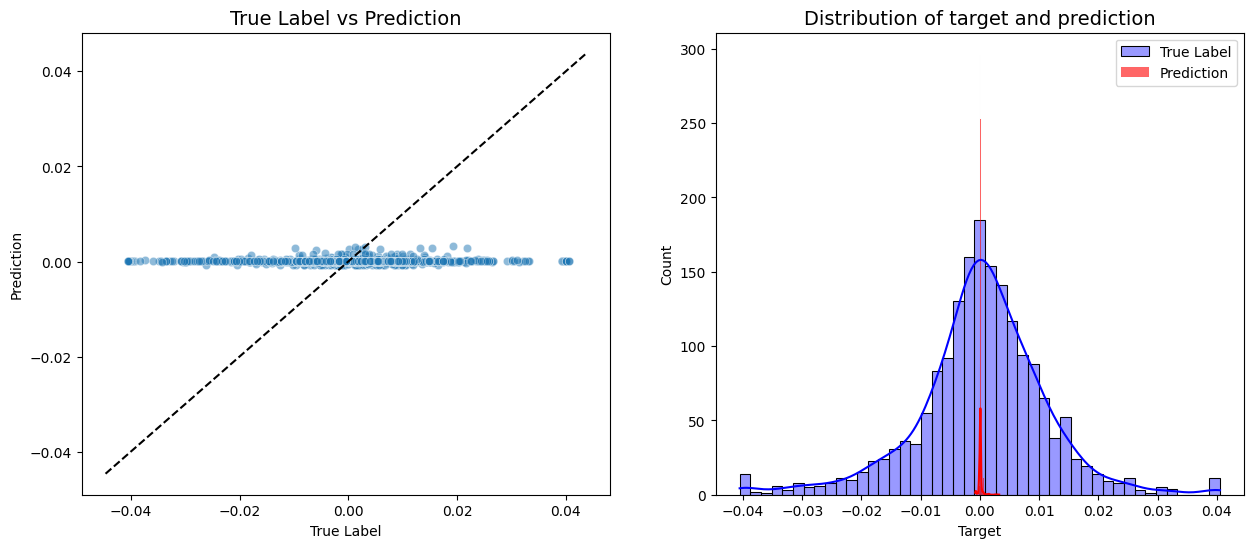

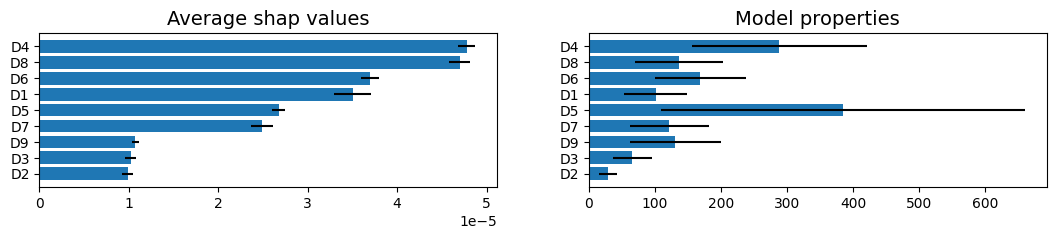

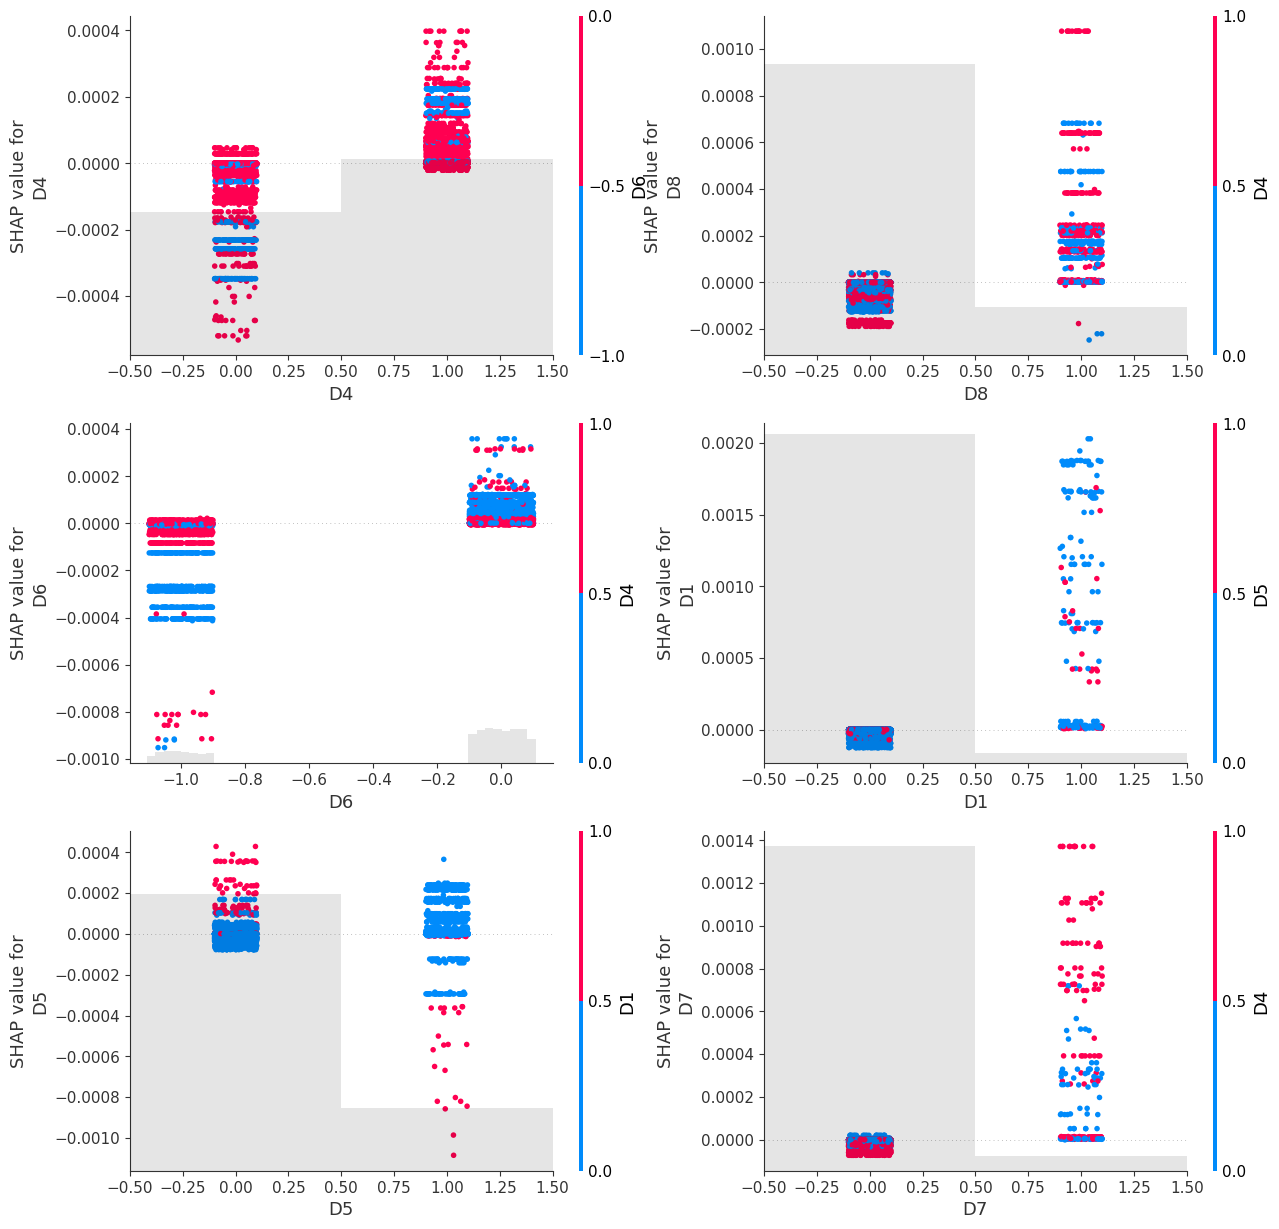

In [13]:
model = lgb.LGBMRegressor(random_state=34, n_jobs=-1, verbose=-1, n_estimators=10000,
                          learning_rate=0.01,
                          colsample_bytree=0.731,
                             min_child_weight=48.1,
                             reg_lambda=95.91,
                             reg_alpha=88.85,
                             subsample=0.497,
                             num_leaves=13,
                             max_depth=45)

callbacks = [lgb.early_stopping(1000, verbose=0)]
fit_params = {"callbacks":callbacks, "eval_metric": "rmse", "sample_weight": "date_id"}

processing = Pipeline([("fe", FeatureEng()),
                     #   ("imputer", tml.DfImputer(strategy="mean", fill_value=0)),
                       ("sel", ColumnSelector(patterns=[("D", "startswith")])),
                     #   ("scaler", tml.DfScaler(method="robust"))
                            ])

pipe = Pipeline([("processing", processing),
                ("model", model)])

train = make_lags_train(df)

FEATURES = [c for c in train.columns if c not in DROP]

cvscore = TSCrossValidate(data=train[FEATURES], target=train[TARGET], cv=ts_folds, estimator=pipe, shap=True, imp_coef=True, fit_params=fit_params, early_stopping=True)
oof_d, res = cvscore.score()

pos_d = np.clip(oof_d * 977 + 1, 0, 2)

print(res["iterations"])

summary_evaluation(res["folds_eval"], df, factor=977)

tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="both")

to_plot = res["feat_imp"].head(6)["Feature"].to_list()
tml.plot_shap_values(res["shap_values"], features=to_plot)

[1, 380, 1, 10, 1, 1, 839, 540, 198, 976]
Mean Squared Error: 0.00012
R2: 0.004116645613118863
MAE: 0.007909223513410526
               min      mean       max
fold                                  
0     4.132224e-10  0.000110  0.001542
1     2.833531e-10  0.000060  0.000917
2     1.355266e-10  0.000322  0.001624
3     9.782316e-10  0.000079  0.001196
4     1.121835e-09  0.000103  0.000896
5     1.078350e-09  0.000246  0.001648
6     8.384098e-10  0.000077  0.000625
7     7.761899e-10  0.000054  0.000383
8     1.249611e-09  0.000069  0.000923
9     1.421003e-09  0.000114  0.001755
Sharpe: 0.8829900682972154
0 -0.24331758890453142
1 2.2190574980511895
2 0.6153862207586646
3 2.472782514087182
4 0.40398893968797406
5 -0.7650207224721924
6 1.1421464427980812
7 1.734108702612109
8 1.0147468269214155
9 1.2976047550991705


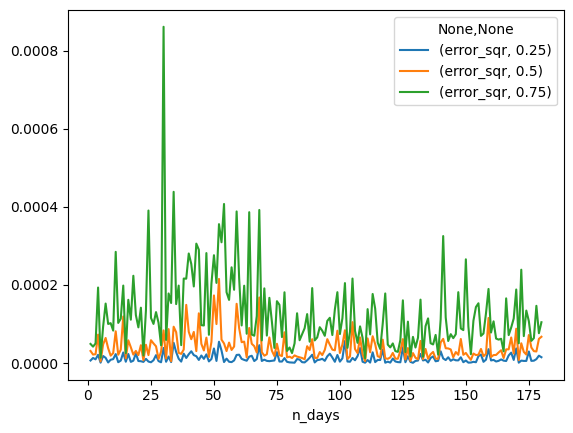

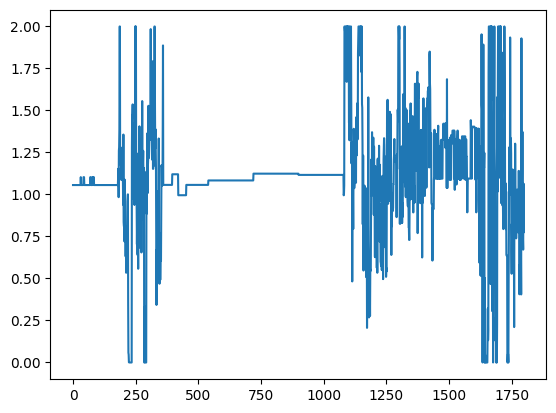

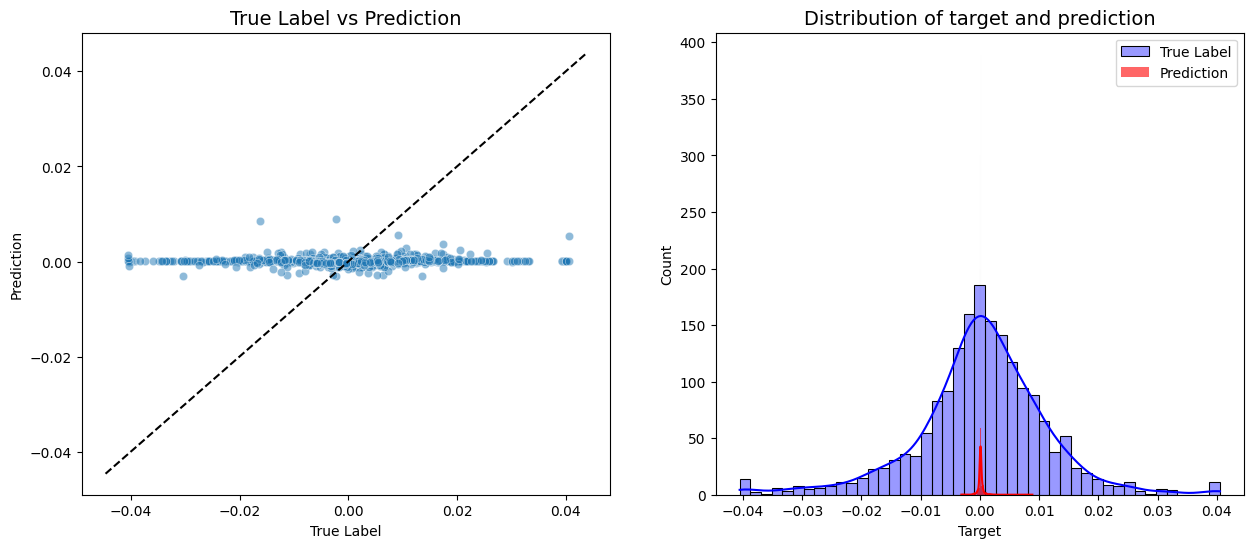

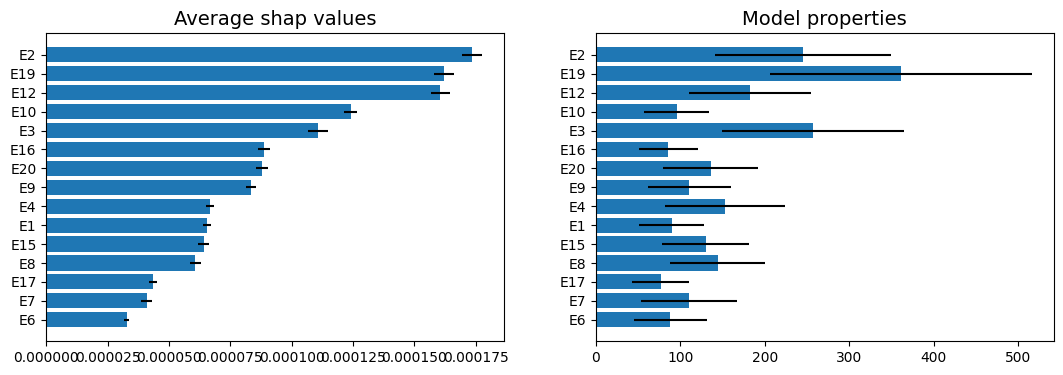

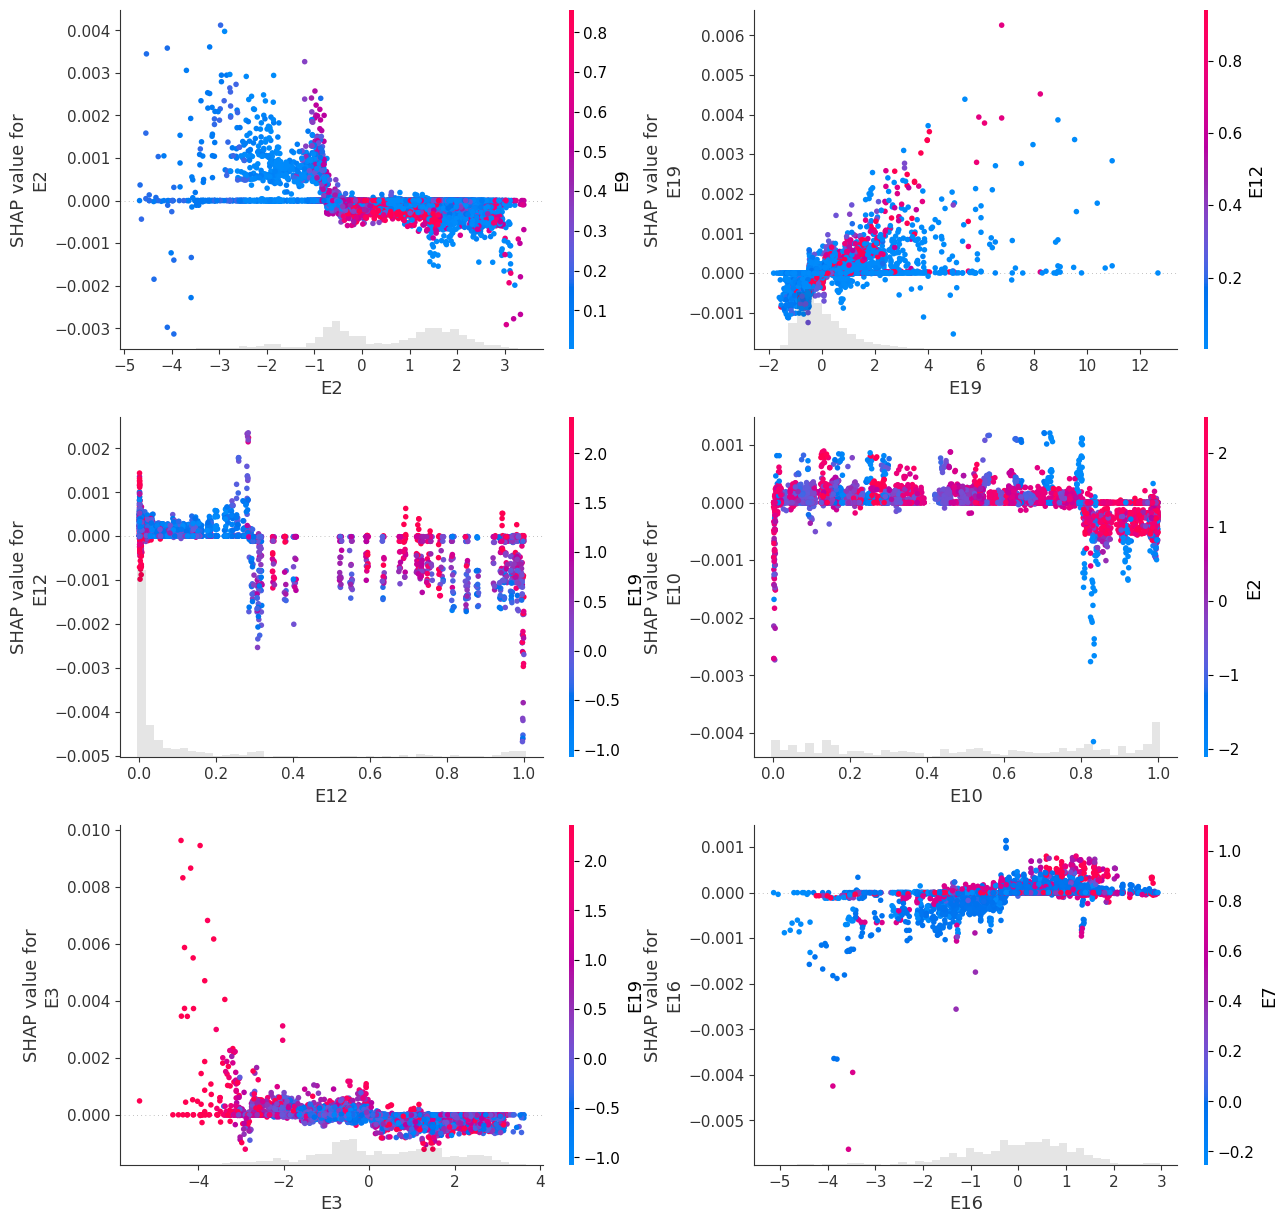

In [14]:
model = lgb.LGBMRegressor(random_state=34, n_jobs=-1, verbose=-1, n_estimators=10000,
                          learning_rate=0.01,
                          colsample_bytree=0.697,
                             min_child_weight=14.5,
                             reg_lambda=88.44,
                             reg_alpha=22.26,
                             subsample=0.427,
                             num_leaves=10,
                             max_depth=77)

callbacks = [lgb.early_stopping(1000, verbose=0)]
fit_params = {"callbacks":callbacks, "eval_metric": "rmse", "sample_weight": "date_id"}

processing = Pipeline([("fe", FeatureEng()),
                       ("imputer", tml.DfImputer(strategy="mean", fill_value=0)),
                       ("sel", ColumnSelector(patterns=[("E", "startswith")]))
                       #("scaler", tml.DfScaler())
                            ])

pipe = Pipeline([("processing", processing),
                ("model", model)])

train = make_lags_train(df)

FEATURES = [c for c in train.columns if c not in DROP]

cvscore = TSCrossValidate(data=train[FEATURES], target=train[TARGET], cv=ts_folds, estimator=pipe, shap=True, imp_coef=True, fit_params=fit_params, early_stopping=True)
oof_e, res = cvscore.score()

pos_e = np.clip(oof_e * 948 + 1, 0, 2)

print(res["iterations"])

summary_evaluation(res["folds_eval"], df, factor=948)

tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="both")

to_plot = res["feat_imp"].head(6)["Feature"].to_list()
tml.plot_shap_values(res["shap_values"], features=to_plot)

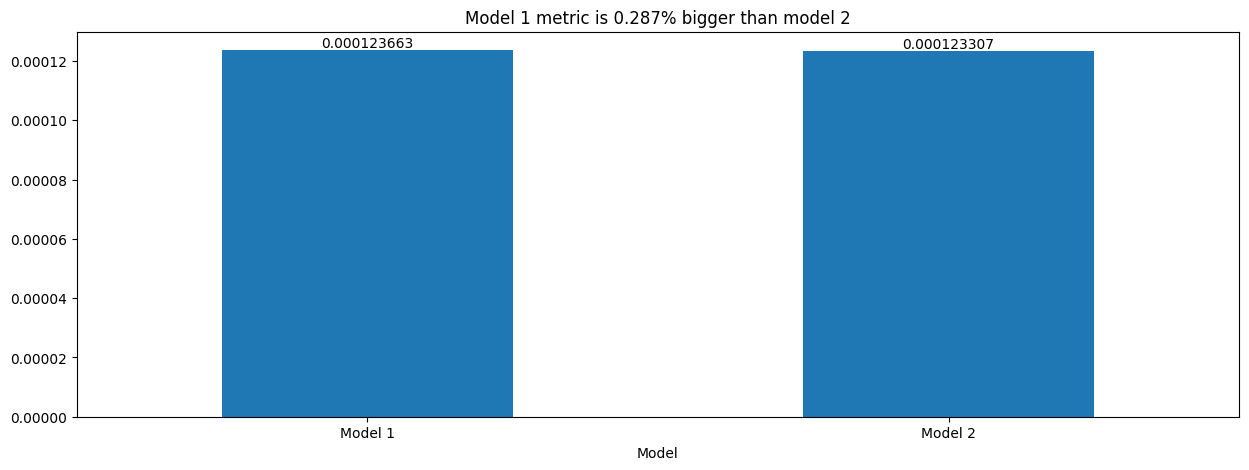

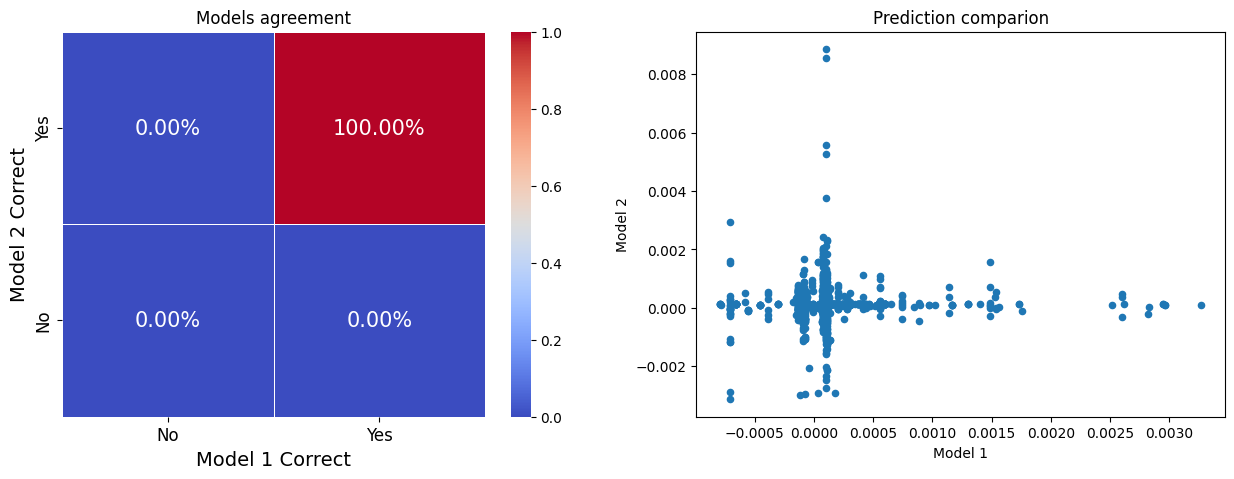

In [15]:
comparison = tml.CompareModels(data=df.tail(1800).reset_index(drop=True),
                               true_label=df.tail(1800).reset_index(drop=True)[TARGET],
                                       pred_1=oof_d[-1800:], pred_2=oof_e[-1800:],
                                       kfold=ts_folds,
                                       regression=True,
                                       probabilities=True,
                                       metric_func=mean_squared_error)
    
comparison.compare_metrics()
comparison.compare_predictions()

[1, 2, 1, 69, 4, 1, 19, 31, 3, 3]
Mean Squared Error: 0.00012
R2: 0.001256489224529922
MAE: 0.007926135119532274
               min      mean       max
fold                                  
0     1.529522e-09  0.000110  0.001544
1     2.847454e-09  0.000061  0.000922
2     1.572552e-10  0.000322  0.001629
3     1.864199e-10  0.000078  0.001184
4     2.305713e-08  0.000102  0.000885
5     2.844337e-09  0.000246  0.001647
6     3.305608e-09  0.000077  0.000599
7     2.775808e-09  0.000054  0.000390
8     2.513817e-12  0.000069  0.000924
9     5.173426e-09  0.000117  0.001655
Sharpe: 0.7804263343037232
0 -0.30883547419336804
1 1.5954577713018734
2 0.5934647584482731
3 2.8337600529508844
4 0.557787799643426
5 -0.7712899767946
6 1.4090616293791032
7 1.4793071446167751
8 1.0801666659634857
9 0.8222619912979189


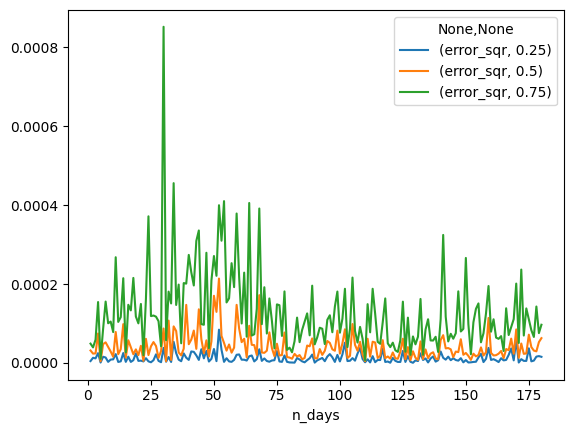

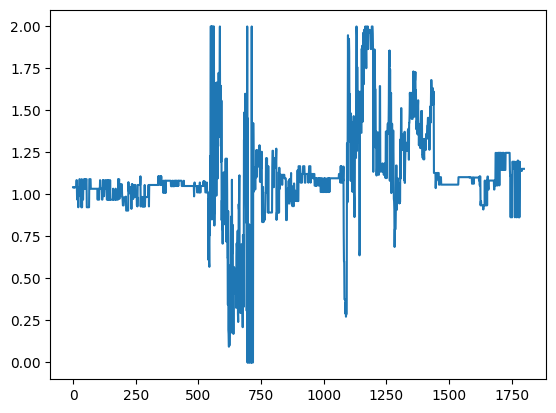

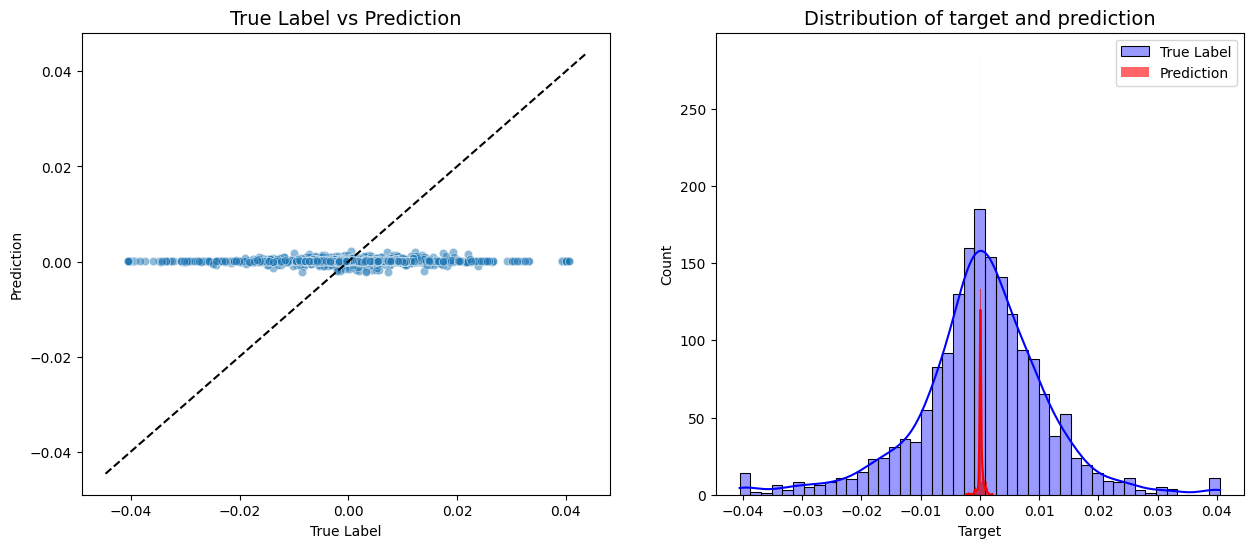

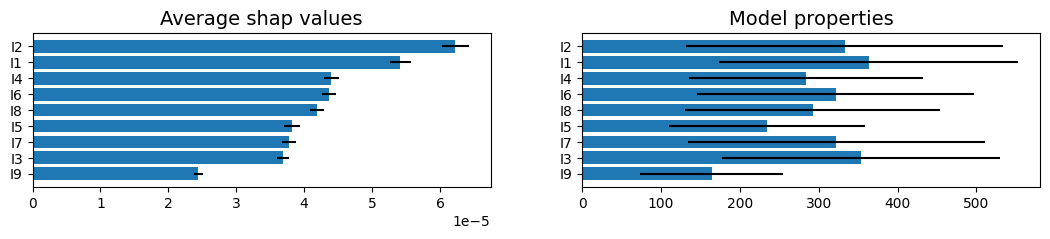

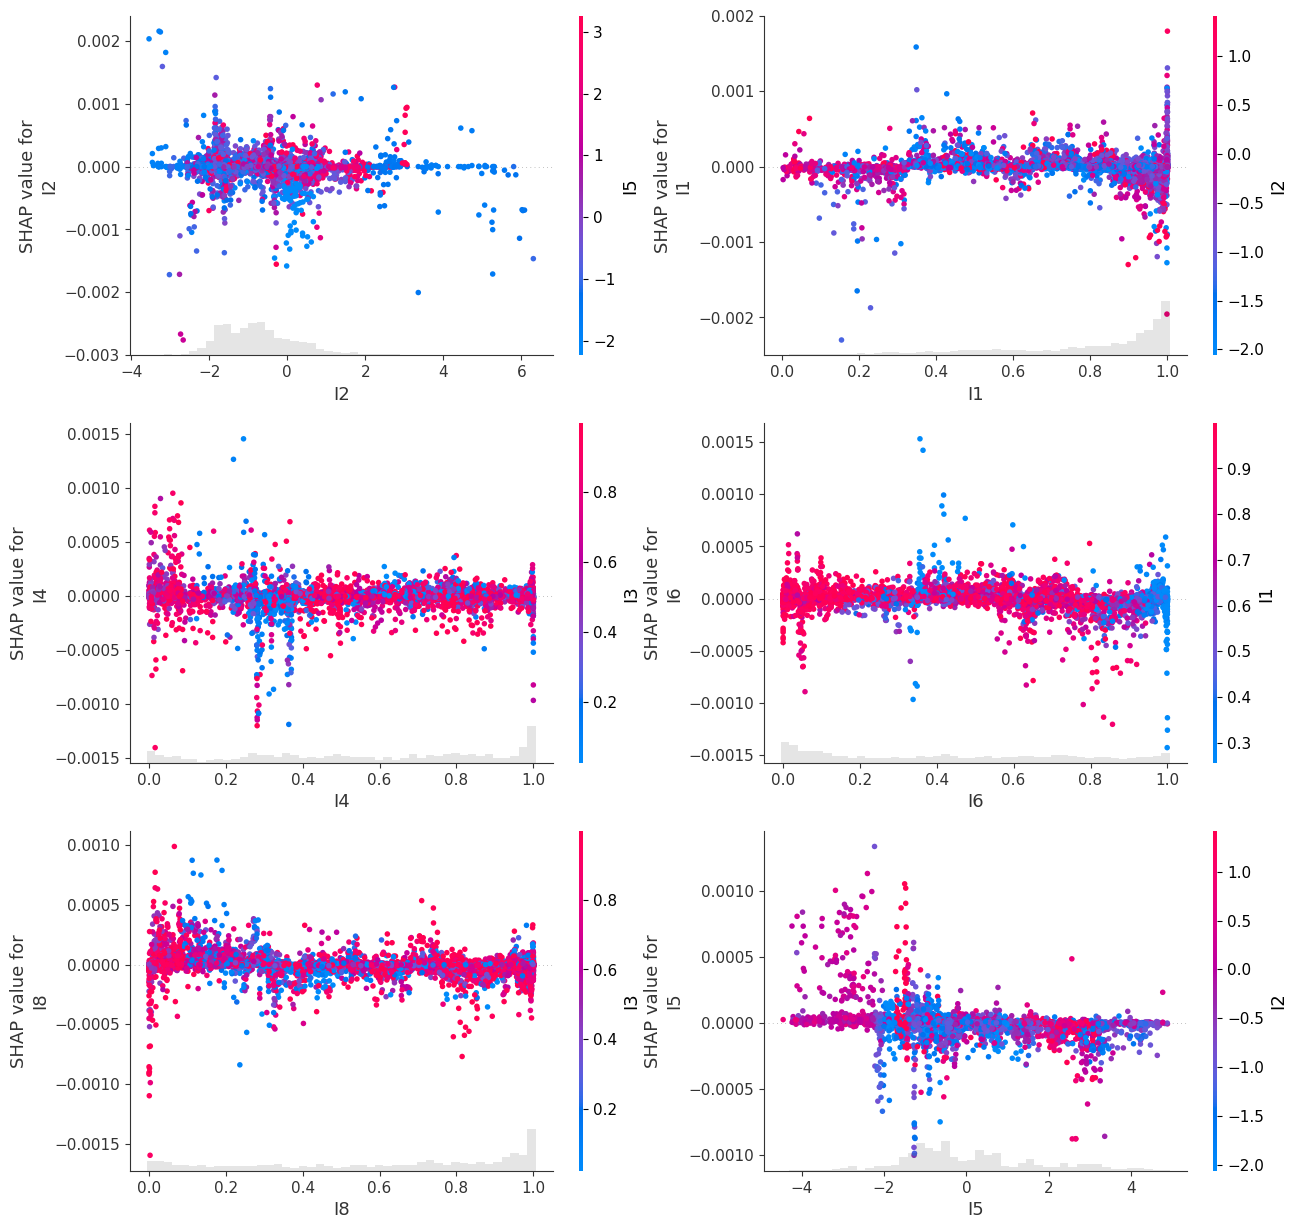

In [16]:
model = lgb.LGBMRegressor(random_state=34, n_jobs=-1, verbose=-1, n_estimators=10000,
                          learning_rate=0.01,
                          colsample_bytree=0.798,
                             min_child_weight=207,
                             reg_lambda=12.5,
                             reg_alpha=7.85,
                             subsample=0.713,
                             num_leaves=200,
                             max_depth=78)

callbacks = [lgb.early_stopping(1000, verbose=0)]
fit_params = {"callbacks":callbacks, "eval_metric": "rmse", "sample_weight": "date_id"}

processing = Pipeline([("fe", FeatureEng()),
                       ("imputer", tml.DfImputer(strategy="median", fill_value=0)),
                       ("sel", ColumnSelector(patterns=[("I", "startswith")])),
                       #("scaler", tml.DfScaler(method="robust"))
                            ])

pipe = Pipeline([("processing", processing),
                ("model", model)])

train = make_lags_train(df)

FEATURES = [c for c in train.columns if c not in DROP]

cvscore = TSCrossValidate(data=train[FEATURES], target=train[TARGET], cv=ts_folds, estimator=pipe, shap=True, imp_coef=True, fit_params=fit_params, early_stopping=True)
oof_i, res = cvscore.score()

pos_i = np.clip(oof_i * 851 + 1, 0, 2)

print(res["iterations"])

summary_evaluation(res["folds_eval"], df, factor=851)

tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="both")

to_plot = res["feat_imp"].head(6)["Feature"].to_list()
tml.plot_shap_values(res["shap_values"], features=to_plot)

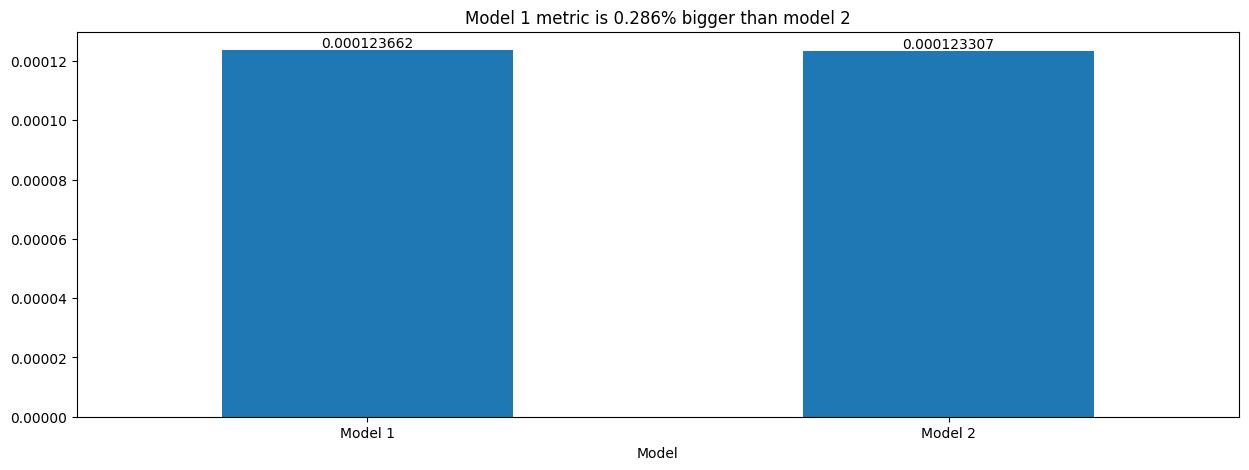

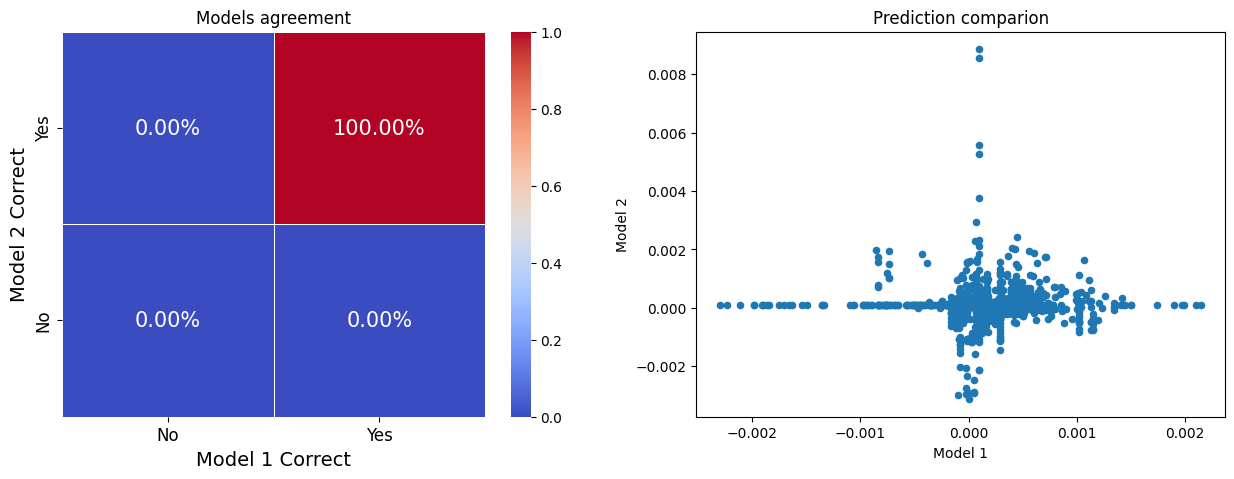

In [17]:
comparison = tml.CompareModels(data=df.tail(1800).reset_index(drop=True),
                               true_label=df.tail(1800).reset_index(drop=True)[TARGET],
                                       pred_1=oof_i[-1800:], pred_2=oof_e[-1800:],
                                       kfold=ts_folds,
                                       regression=True,
                                       probabilities=True,
                                       metric_func=mean_squared_error)
    
comparison.compare_metrics()
comparison.compare_predictions()

 92%|==================  | 646/700 [00:19<00:01]       

[19, 592, 102, 1, 55, 10, 159, 72, 88, 477]
Mean Squared Error: 0.00012
R2: 0.009945519386401758
MAE: 0.007875800828022143
               min      mean       max
fold                                  
0     7.915521e-11  0.000109  0.001407
1     2.081586e-11  0.000059  0.001089
2     4.867322e-08  0.000319  0.002010
3     1.478114e-09  0.000079  0.001199
4     4.619520e-09  0.000101  0.001004
5     3.606421e-08  0.000246  0.001665
6     7.362380e-12  0.000076  0.000480
7     5.642969e-09  0.000054  0.000403
8     1.308757e-09  0.000069  0.000900
9     1.561105e-09  0.000115  0.001852
Sharpe: 0.7951578660955101
0 0.10194535939963294
1 1.3581882943055608
2 0.5808839016722018
3 2.4765365316909826
4 0.6372754979543334
5 -0.6559953196158648
6 2.0785115542638555
7 1.9580294873343642
8 1.371826530846951
9 1.174679868164781


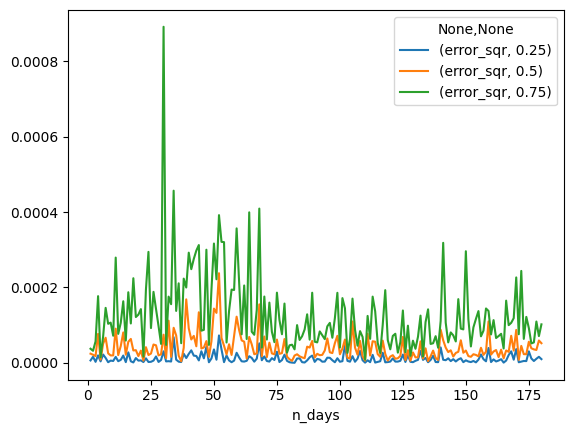

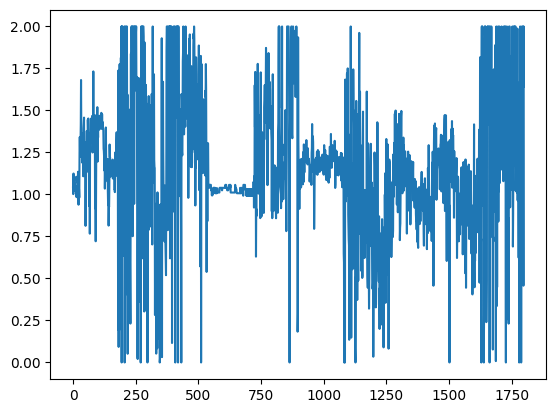

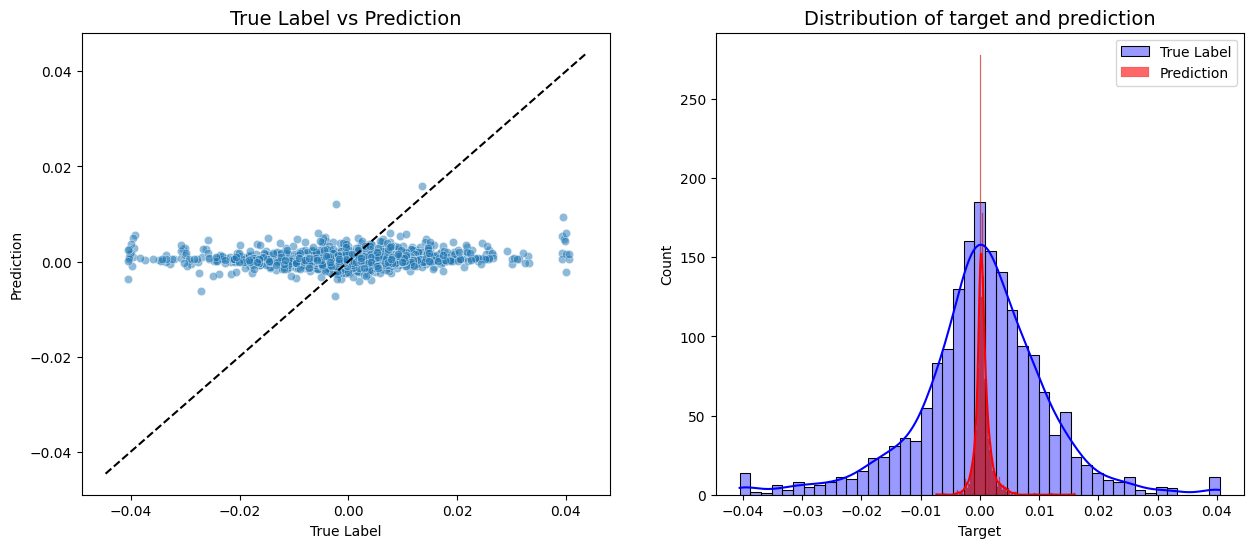

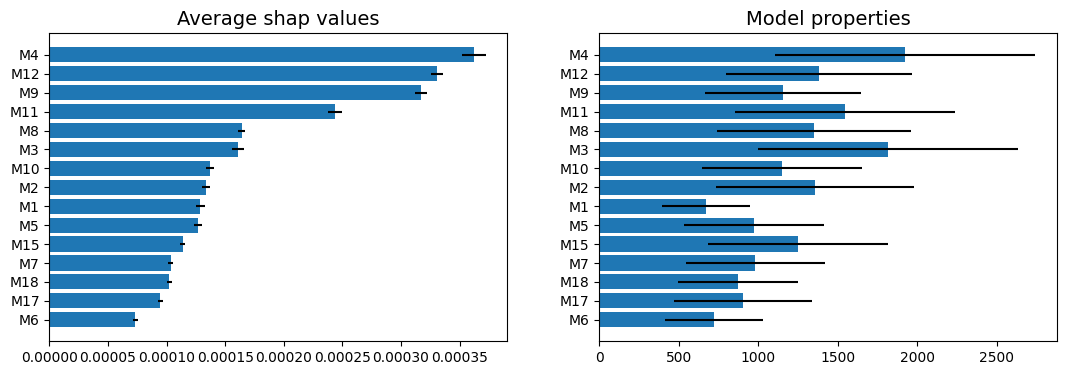

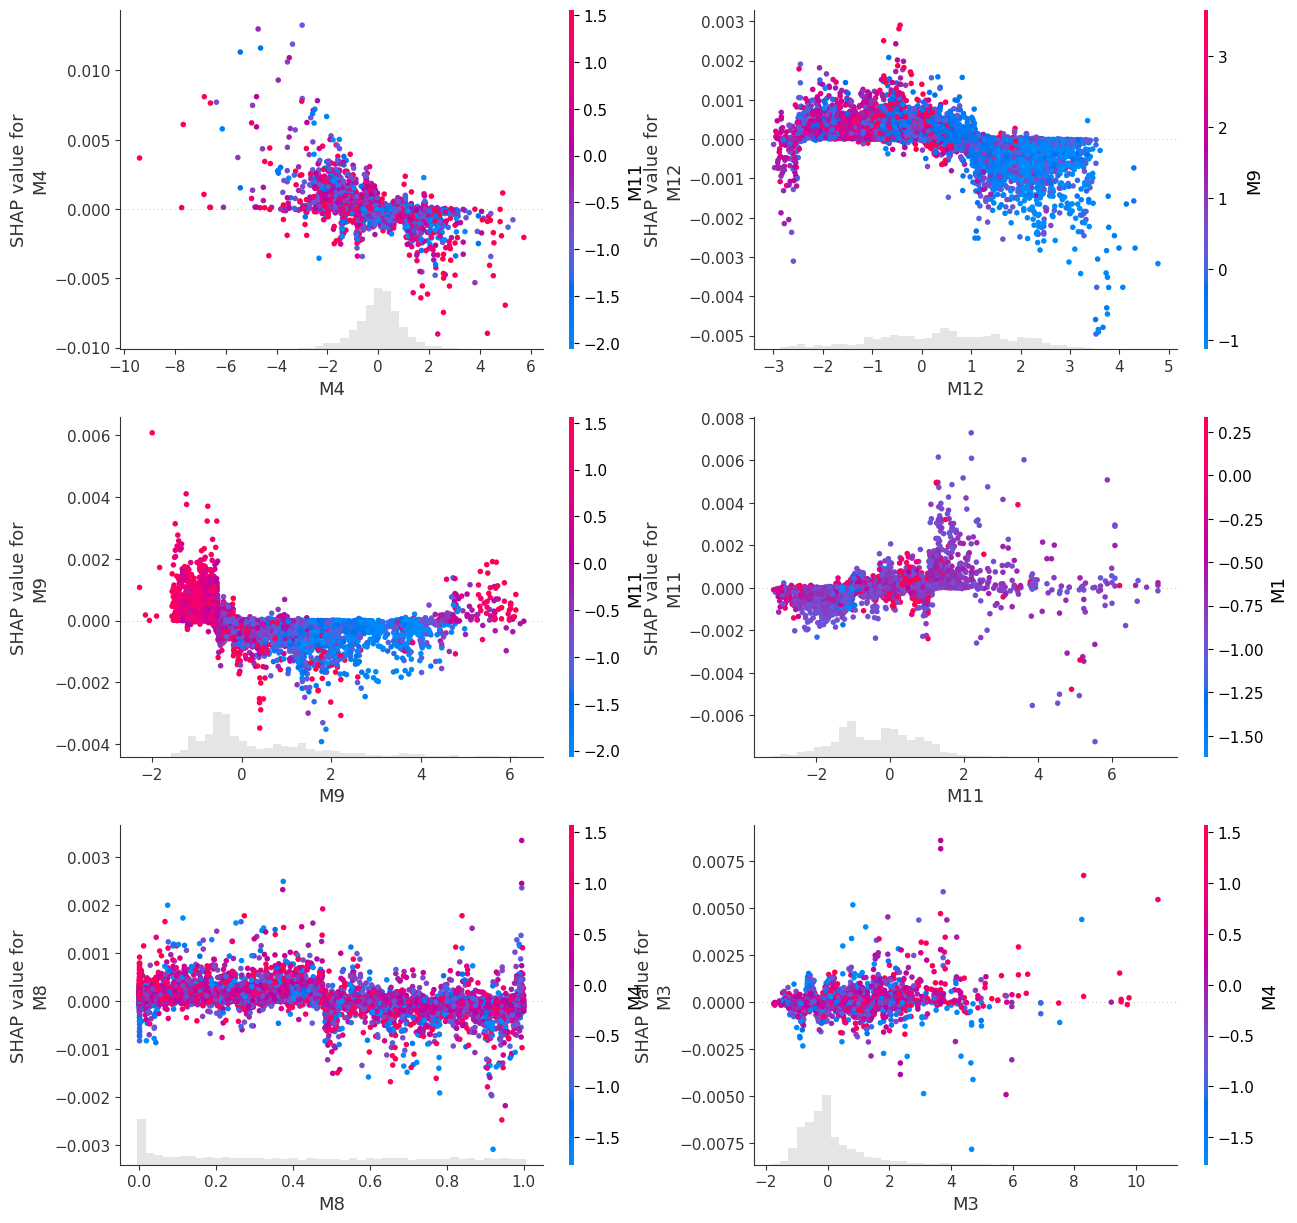

In [18]:
model = lgb.LGBMRegressor(random_state=34, n_jobs=-1, verbose=-1, n_estimators=10000,
                          learning_rate=0.01,
                          colsample_bytree=0.658,
                             min_child_weight=259.89,
                             reg_lambda=63.58,
                             reg_alpha=12.03,
                             subsample=0.678,
                             num_leaves=123,
                             max_depth=300)

callbacks = [lgb.early_stopping(1000, verbose=0)]
fit_params = {"callbacks":callbacks, "eval_metric": "rmse", "sample_weight": "date_id"}

processing = Pipeline([("fe", FeatureEng()),
                       ("imputer", tml.DfImputer(strategy="median", fill_value=0)),
                       ("sel", ColumnSelector(patterns=[("M", "startswith")]))
                       #("scaler", tml.DfScaler())
                            ])

pipe = Pipeline([("processing", processing),
                ("model", model)])

train = make_lags_train(df)

FEATURES = [c for c in train.columns if c not in DROP]

cvscore = TSCrossValidate(data=train[FEATURES], target=train[TARGET], cv=ts_folds, estimator=pipe, shap=True, imp_coef=True, fit_params=fit_params, early_stopping=True)
oof_m, res = cvscore.score()

pos_m = np.clip(oof_m * 402 + 1, 0, 2)

print(res["iterations"])

summary_evaluation(res["folds_eval"], df, factor=402)

tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="both")

to_plot = res["feat_imp"].head(6)["Feature"].to_list()
tml.plot_shap_values(res["shap_values"], features=to_plot)

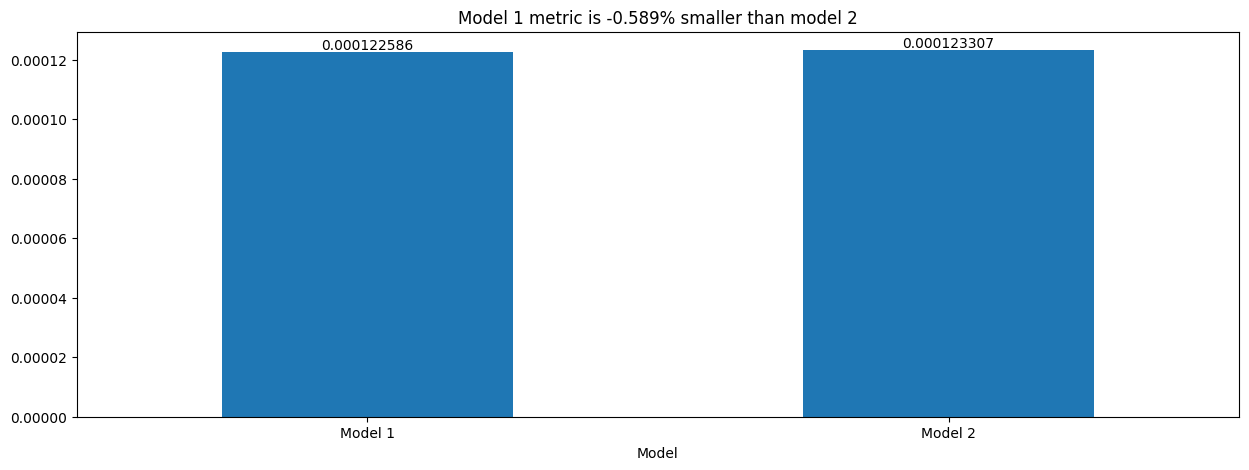

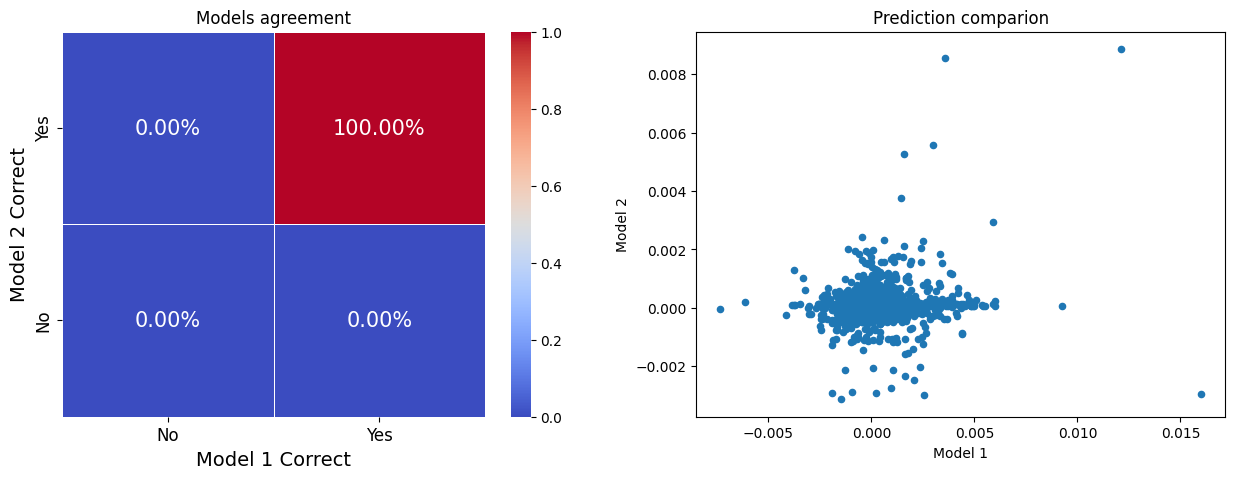

In [19]:
comparison = tml.CompareModels(data=df.tail(1800).reset_index(drop=True),
                               true_label=df.tail(1800).reset_index(drop=True)[TARGET],
                                       pred_1=oof_m[-1800:], pred_2=oof_e[-1800:],
                                       kfold=ts_folds,
                                       regression=True,
                                       probabilities=True,
                                       metric_func=mean_squared_error)
    
comparison.compare_metrics()
comparison.compare_predictions()

 97%|=================== | 680/700 [00:20<00:00]       

[23, 28, 31, 2, 310, 58, 2, 12, 67, 364]
Mean Squared Error: 0.00012
R2: 0.008264441316255922
MAE: 0.007922438850639778
               min      mean       max
fold                                  
0     7.306912e-11  0.000109  0.001499
1     4.241696e-10  0.000060  0.000903
2     8.022574e-10  0.000321  0.001667
3     8.236258e-11  0.000079  0.001187
4     3.247431e-09  0.000098  0.000793
5     2.471028e-09  0.000245  0.001700
6     2.708488e-12  0.000078  0.000624
7     1.189908e-09  0.000054  0.000399
8     6.153904e-10  0.000069  0.000936
9     1.295170e-10  0.000114  0.001926
Sharpe: 0.9705002665211339
0 0.05993564659917495
1 2.0906617143730775
2 0.9338293432138701
3 2.536010039714154
4 1.8785518291349503
5 -0.23250070666466022
6 0.9434890392362599
7 1.6669083189009186
8 1.3702717748897608
9 0.8587192478439433


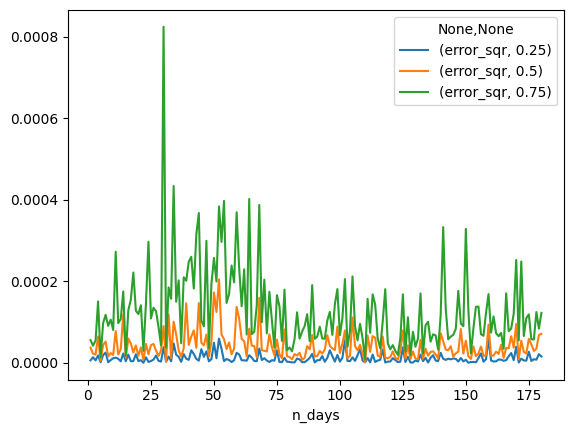

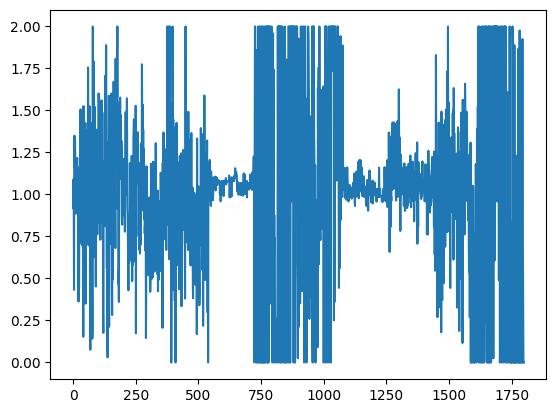

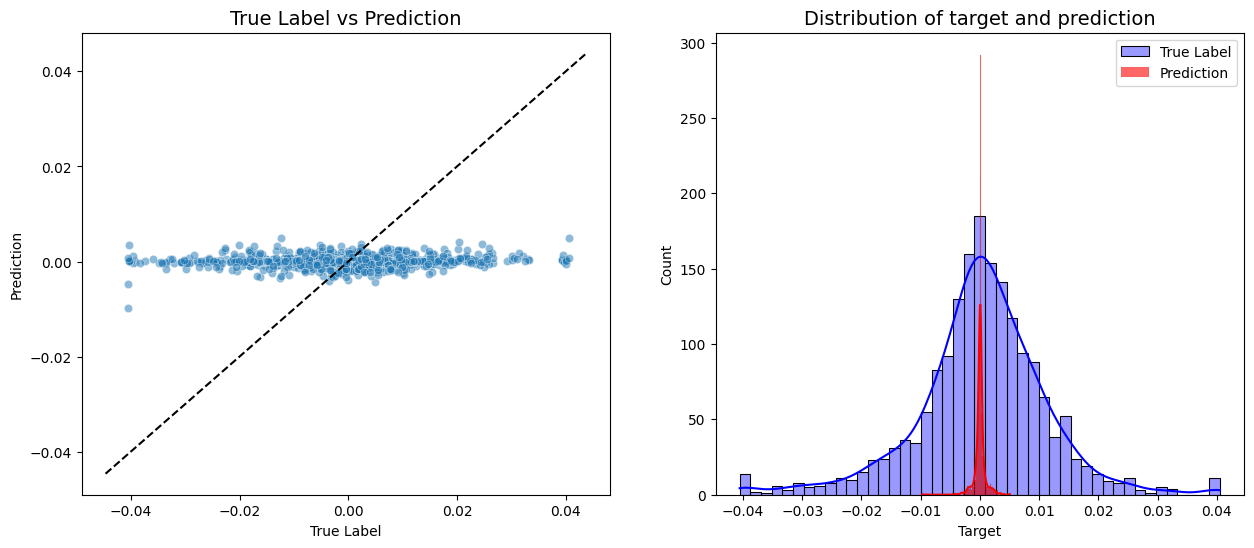

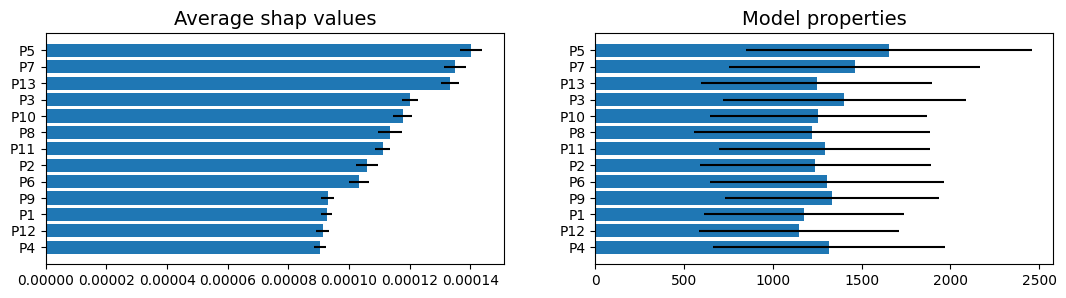

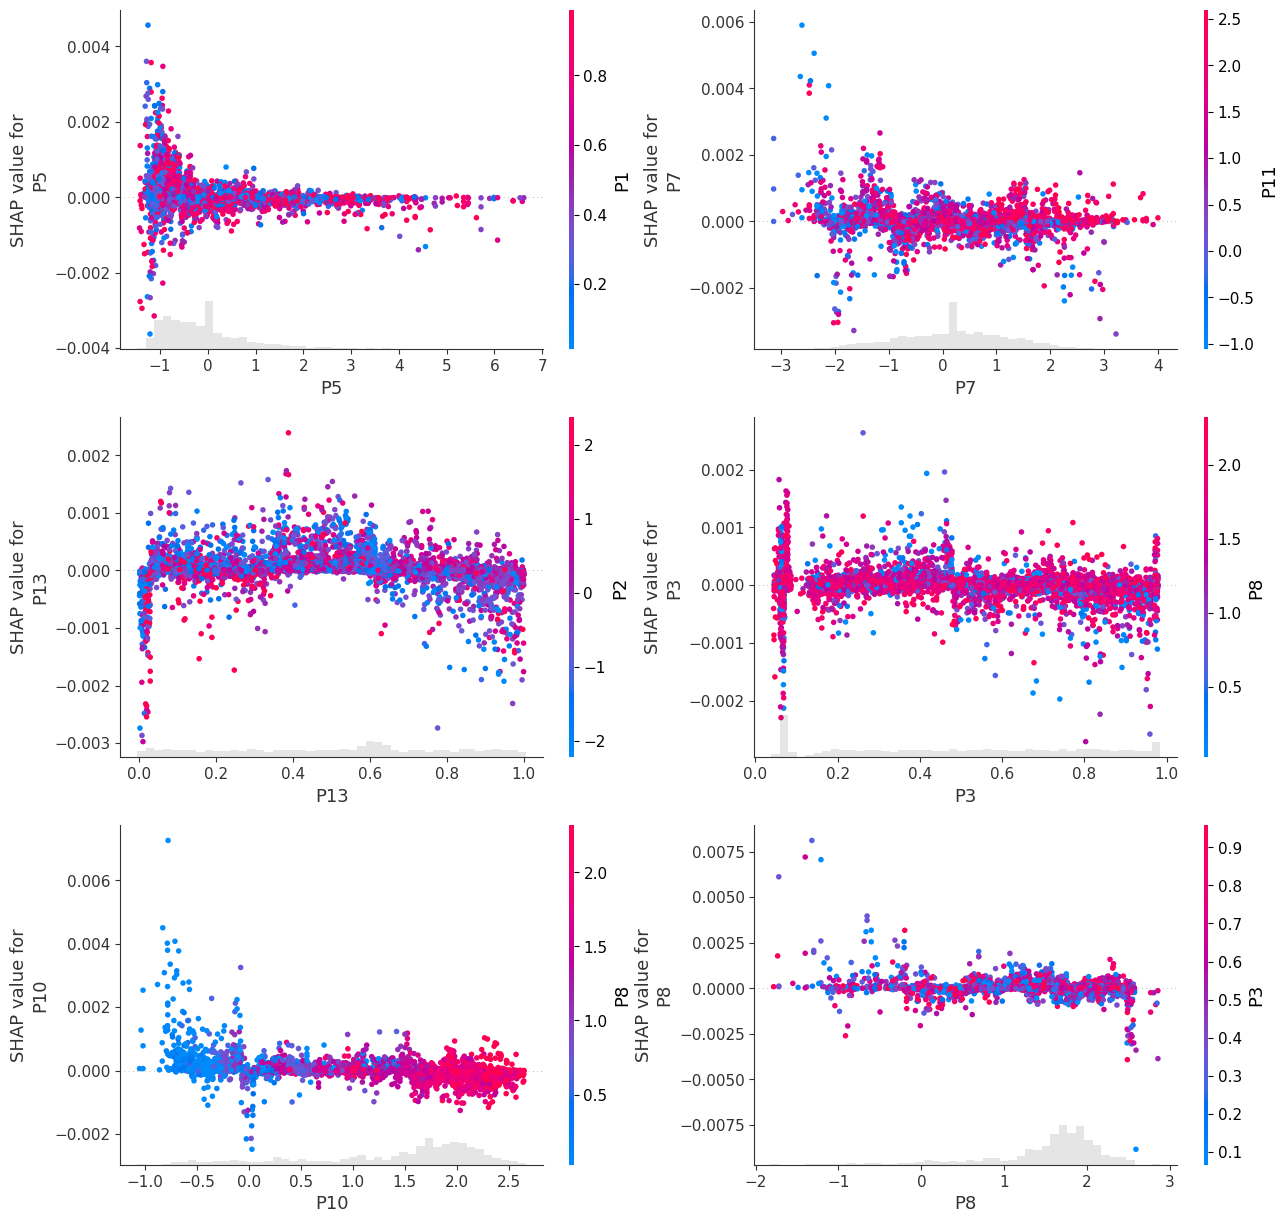

In [20]:
model = lgb.LGBMRegressor(random_state=34, n_jobs=-1, verbose=-1, n_estimators=10000,
                          learning_rate=0.01,
                          colsample_bytree=0.573,
                             min_child_weight=76.42,
                             reg_lambda=97.94,
                             reg_alpha=39.4,
                             subsample=0.98,
                             num_leaves=191,
                             max_depth=66)

callbacks = [lgb.early_stopping(1000, verbose=0)]
fit_params = {"callbacks":callbacks, "eval_metric": "rmse", "sample_weight": "date_id"}

processing = Pipeline([("fe", FeatureEng()),
                       ("imputer", tml.DfImputer(strategy="mean", fill_value=0)),
                       ("sel", ColumnSelector(patterns=[("P", "startswith")]))
                       #("scaler", tml.DfScaler())
                            ])

pipe = Pipeline([("processing", processing),
                ("model", model)])

train = make_lags_train(df)

FEATURES = [c for c in train.columns if c not in DROP]

cvscore = TSCrossValidate(data=train[FEATURES], target=train[TARGET], cv=ts_folds, estimator=pipe, shap=True, imp_coef=True, fit_params=fit_params, early_stopping=True)
oof_p, res = cvscore.score()

pos_p = np.clip(oof_p * 971 + 1, 0, 2)

print(res["iterations"])

summary_evaluation(res["folds_eval"], df, factor=971)

tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="both")

to_plot = res["feat_imp"].head(6)["Feature"].to_list()
tml.plot_shap_values(res["shap_values"], features=to_plot)

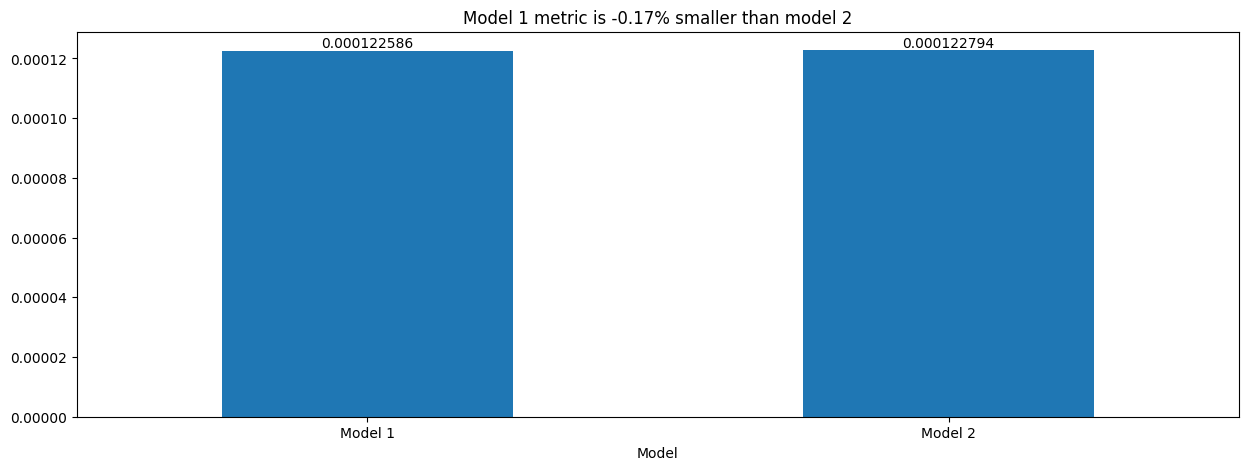

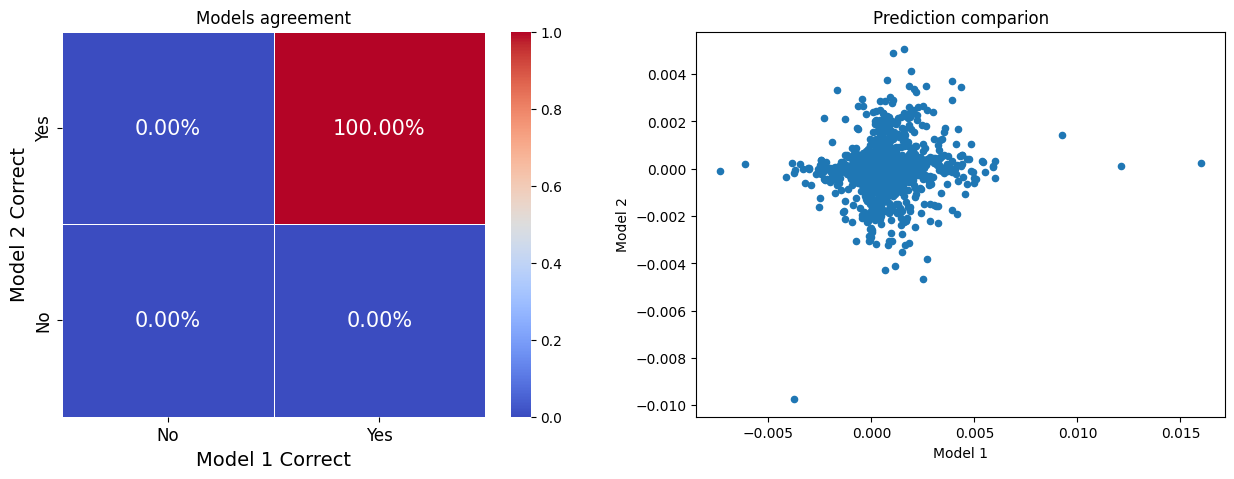

In [21]:
comparison = tml.CompareModels(data=df.tail(1800).reset_index(drop=True),
                               true_label=df.tail(1800).reset_index(drop=True)[TARGET],
                                       pred_1=oof_m[-1800:], pred_2=oof_p[-1800:],
                                       kfold=ts_folds,
                                       regression=True,
                                       probabilities=True,
                                       metric_func=mean_squared_error)
    
comparison.compare_metrics()
comparison.compare_predictions()

[12, 70, 2, 293, 262, 18, 2, 22, 7, 2]
Mean Squared Error: 0.00012
R2: 0.00834097317588356
MAE: 0.00788602155215559
               min      mean       max
fold                                  
0     4.809524e-10  0.000110  0.001431
1     7.278429e-11  0.000059  0.000958
2     4.115146e-10  0.000322  0.001629
3     1.824719e-09  0.000076  0.001188
4     1.347956e-10  0.000098  0.000894
5     1.160905e-11  0.000245  0.001688
6     1.709291e-09  0.000078  0.000621
7     4.410934e-10  0.000054  0.000406
8     4.585206e-10  0.000069  0.000922
9     1.438003e-10  0.000117  0.001659
Sharpe: 0.9366954713396631
0 -0.08141729817986272
1 1.9352081216331016
2 0.6477119679542608
3 3.6766114534559757
4 1.2863820681912226
5 -0.26602850260227817
6 0.9775803019022183
7 1.923808438886509
8 1.1023708729904693
9 0.5318407939151807


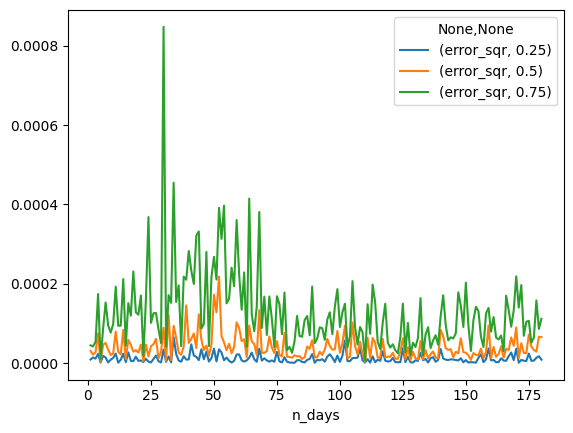

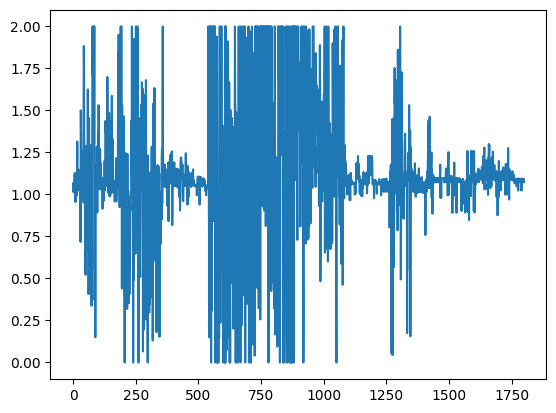

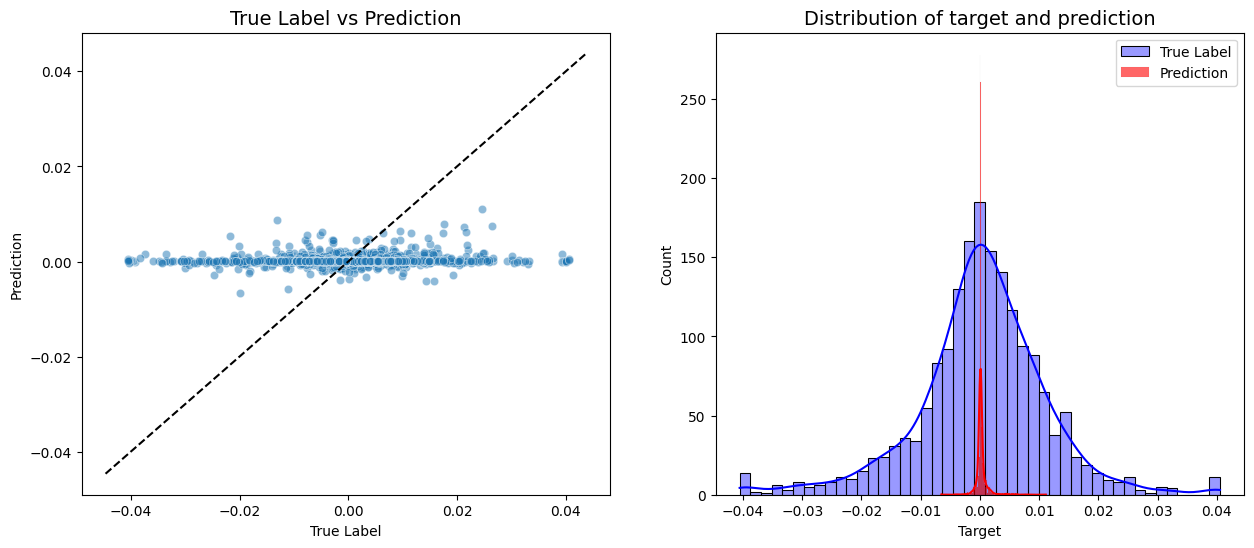

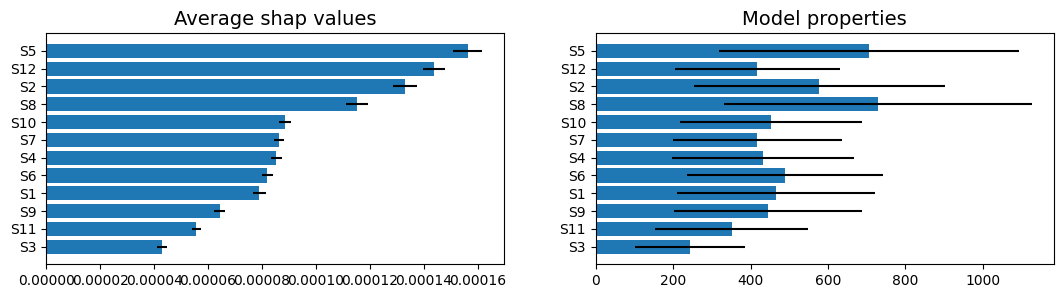

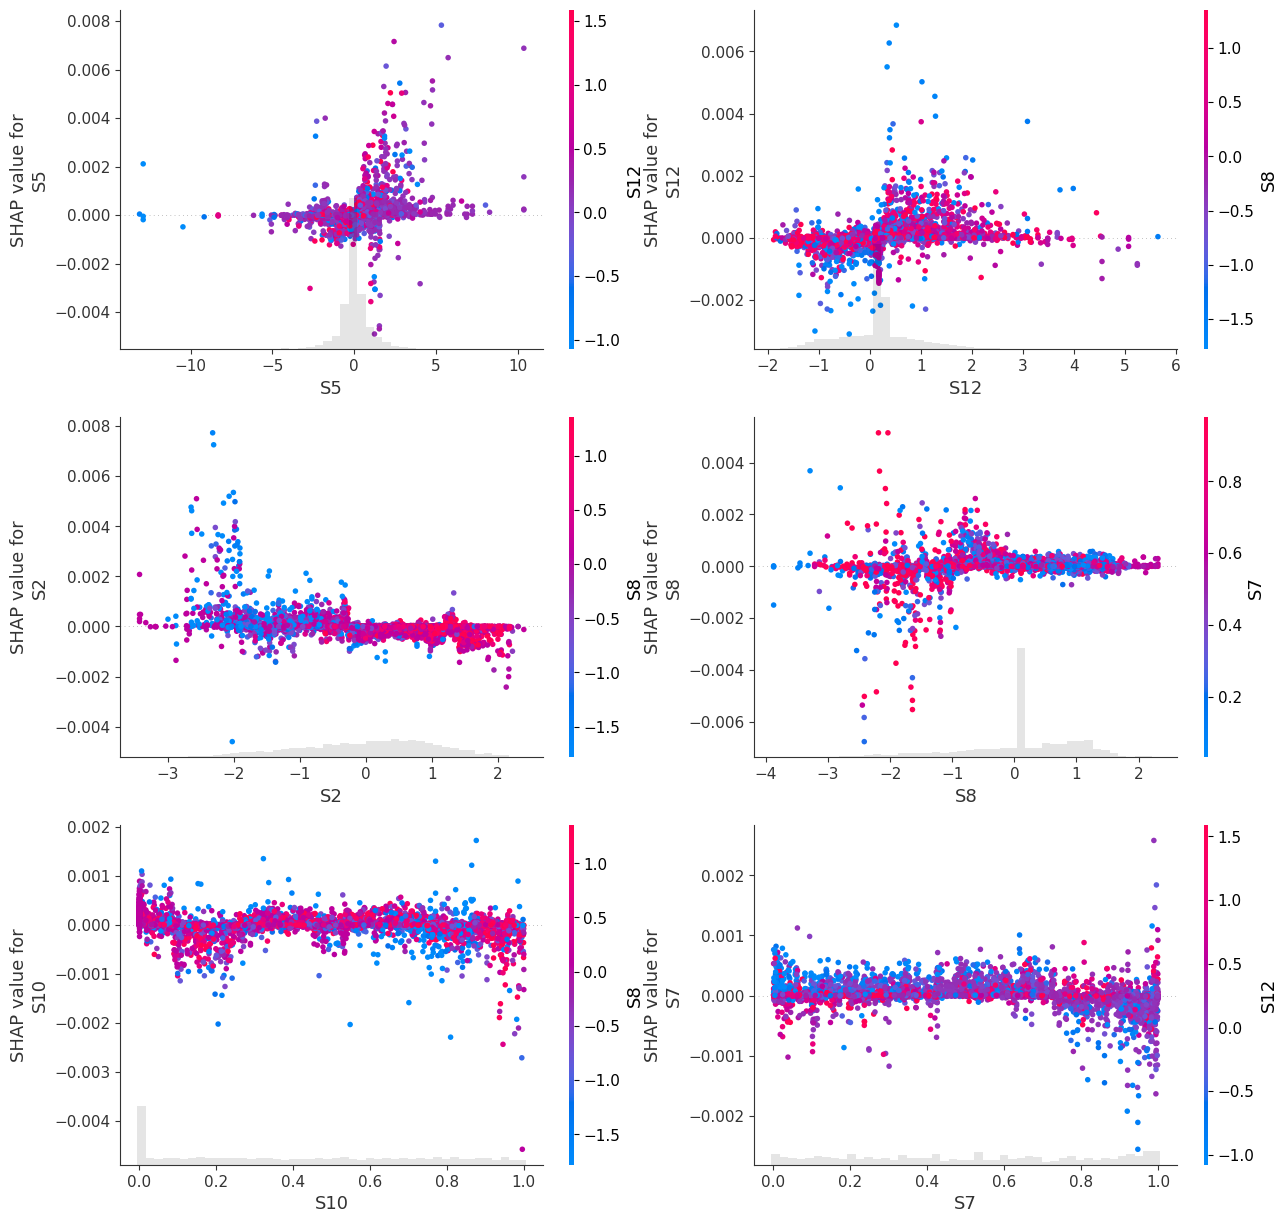

In [22]:
model = lgb.LGBMRegressor(random_state=34, n_jobs=-1, verbose=-1, n_estimators=10000,
                          learning_rate=0.01,
                          colsample_bytree=0.932,
                             min_child_weight=61.98,
                             reg_lambda=27.76,
                             reg_alpha=16.99,
                             subsample=0.593,
                             num_leaves=84,
                             max_depth=172)

callbacks = [lgb.early_stopping(1000, verbose=0)]
fit_params = {"callbacks":callbacks, "eval_metric": "rmse", "sample_weight": "date_id"}

processing = Pipeline([("fe", FeatureEng()),
                       ("imputer", tml.DfImputer(strategy="mean", fill_value=0)),
                       ("sel", ColumnSelector(patterns=[("S", "startswith")]))
                       #("scaler", tml.DfScaler())
                            ])

pipe = Pipeline([("processing", processing),
                ("model", model)])

train = make_lags_train(df)

FEATURES = [c for c in train.columns if c not in DROP]

cvscore = TSCrossValidate(data=train[FEATURES], target=train[TARGET], cv=ts_folds, estimator=pipe, shap=True, imp_coef=True, fit_params=fit_params, early_stopping=True)
oof_s, res = cvscore.score()

pos_s = np.clip(oof_s * 886 + 1, 0, 2)

print(res["iterations"])

summary_evaluation(res["folds_eval"], df, factor=886)

tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="both")

to_plot = res["feat_imp"].head(6)["Feature"].to_list()
tml.plot_shap_values(res["shap_values"], features=to_plot)

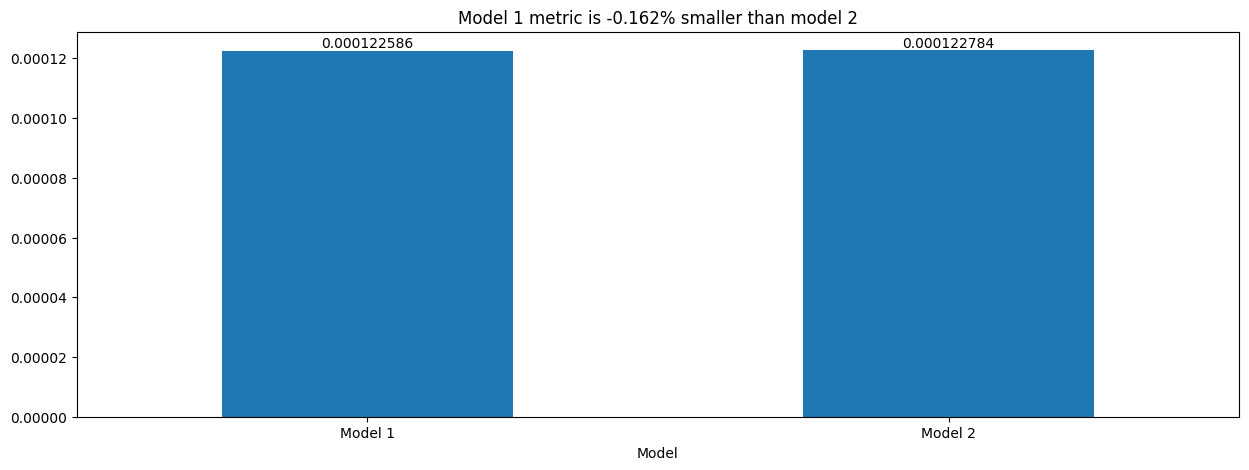

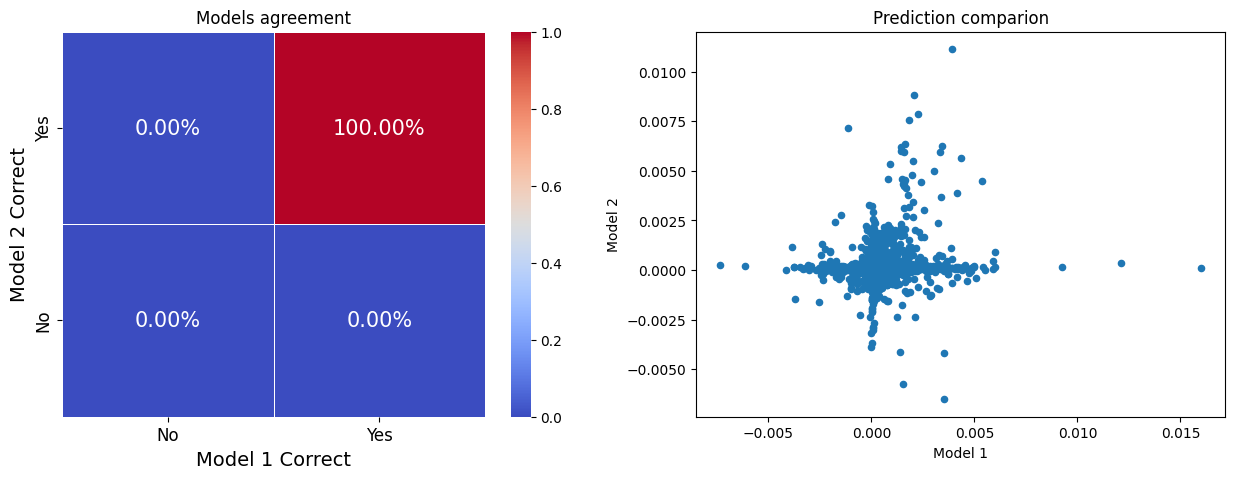

In [23]:
comparison = tml.CompareModels(data=df.tail(1800).reset_index(drop=True),
                               true_label=df.tail(1800).reset_index(drop=True)[TARGET],
                                       pred_1=oof_m[-1800:], pred_2=oof_s[-1800:],
                                       kfold=ts_folds,
                                       regression=True,
                                       probabilities=True,
                                       metric_func=mean_squared_error)
    
comparison.compare_metrics()
comparison.compare_predictions()

[1, 258, 1, 33, 2, 1, 555, 301, 335, 43]
Mean Squared Error: 0.00012
R2: 0.00974992452433332
MAE: 0.007880879199613498
               min      mean       max
fold                                  
0     9.712869e-10  0.000110  0.001534
1     9.409814e-12  0.000056  0.000964
2     9.002504e-09  0.000322  0.001622
3     1.048270e-10  0.000078  0.001397
4     6.640773e-09  0.000103  0.000885
5     1.047970e-09  0.000246  0.001642
6     1.346554e-08  0.000075  0.000492
7     4.067908e-10  0.000053  0.000399
8     8.907669e-09  0.000068  0.000915
9     2.776204e-09  0.000116  0.001668
Sharpe: 1.0768495012110733
0 -0.22842610453922402
1 2.65561899819956
2 0.6390104250232154
3 1.8971288152500838
4 0.4314944493664242
5 -0.7597581260349808
6 2.2631598188066344
7 3.2192903697264317
8 1.3849441379250809
9 0.8600343594290144


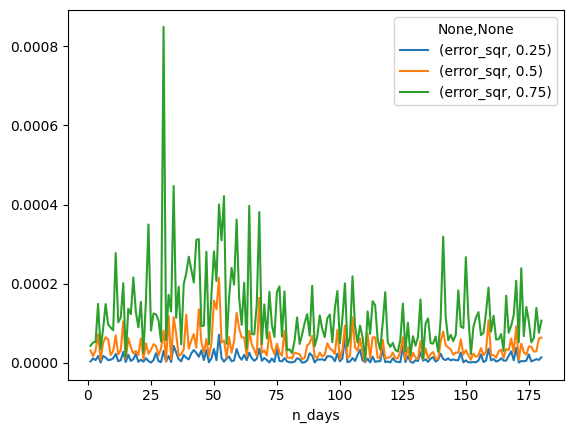

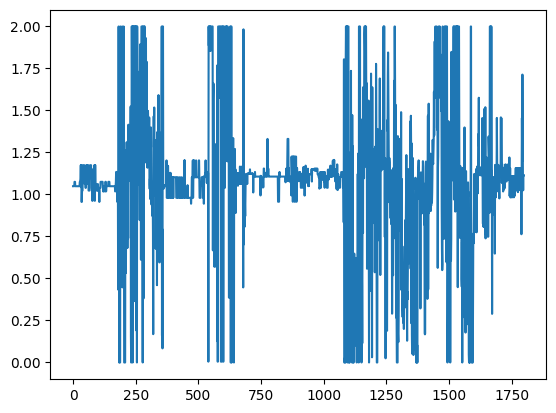

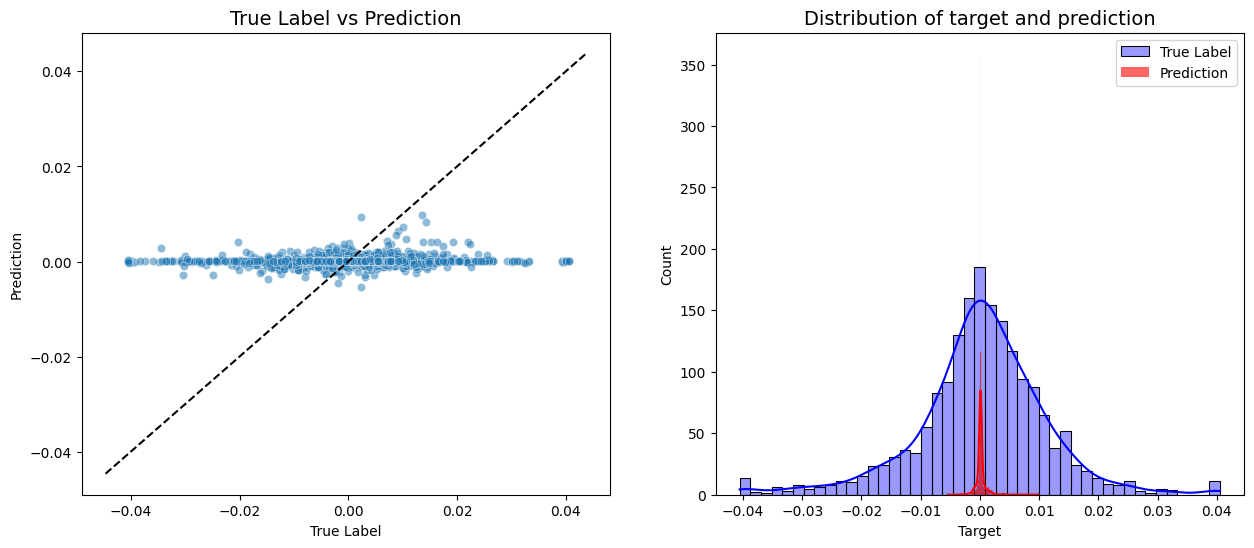

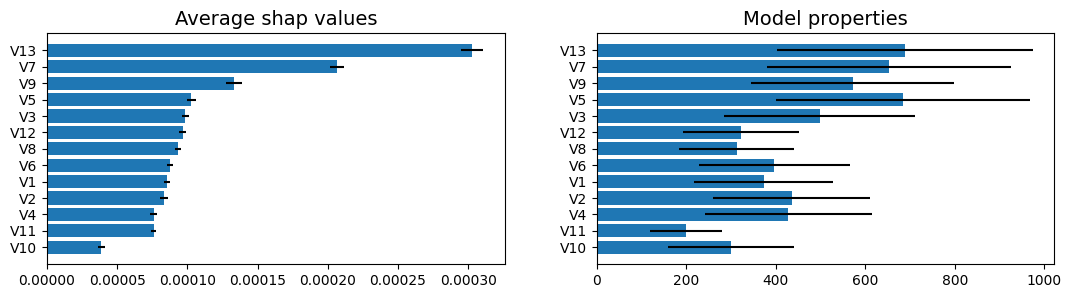

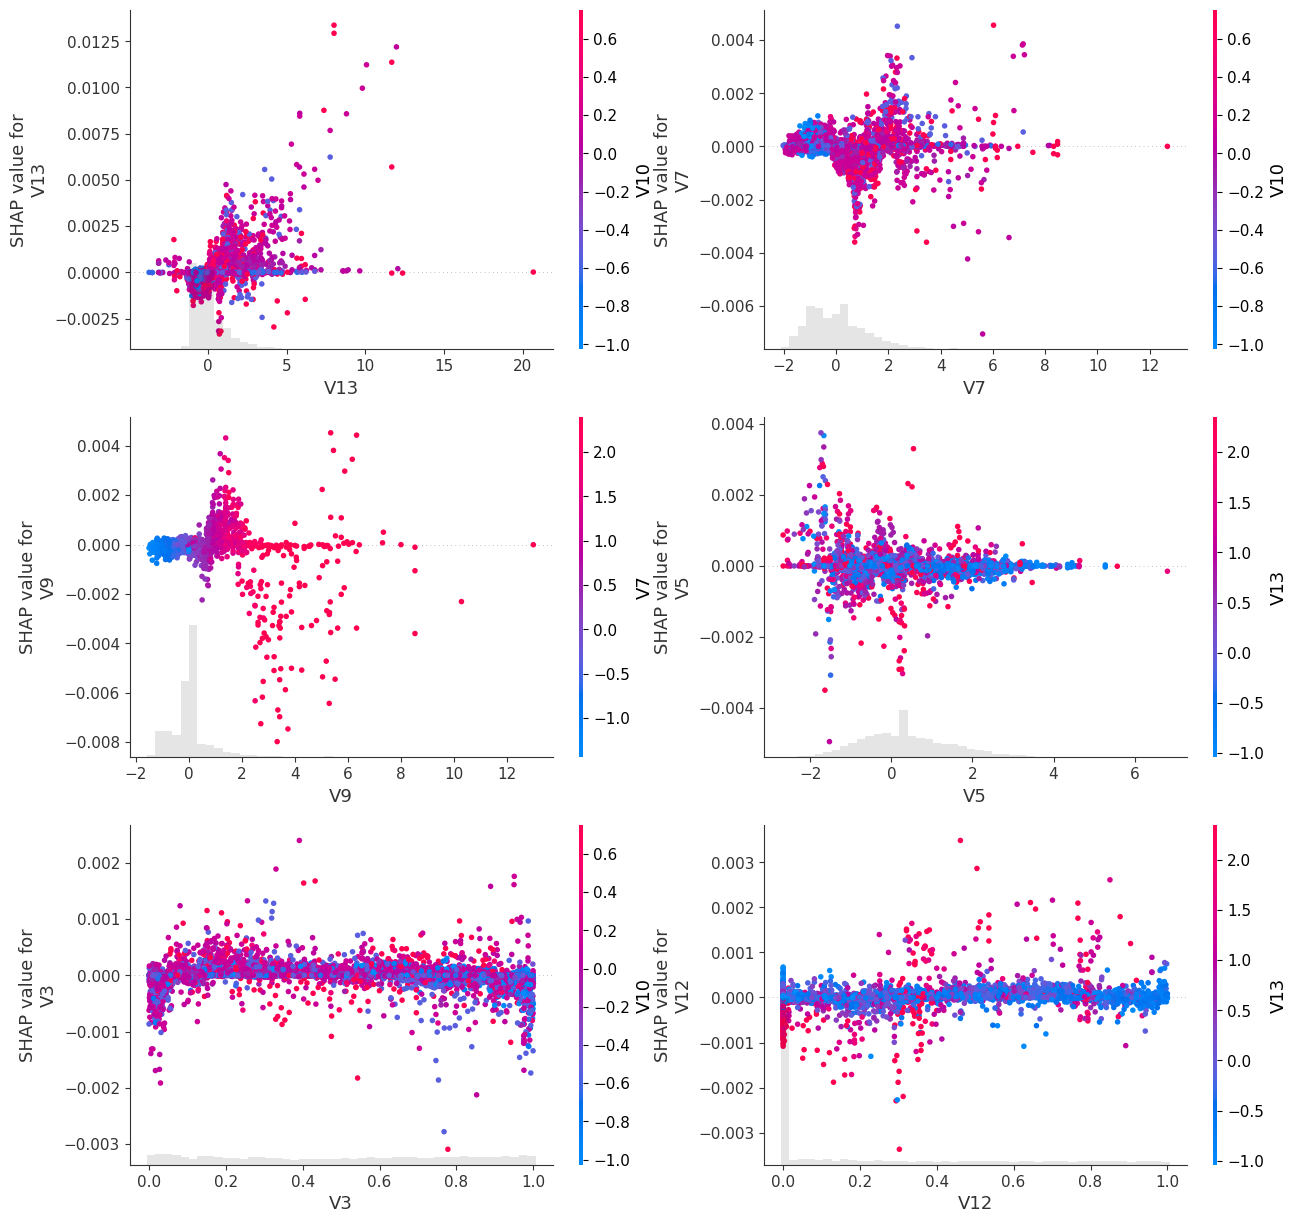

In [24]:
model = lgb.LGBMRegressor(random_state=34, n_jobs=-1, verbose=-1, n_estimators=10000,
                          learning_rate=0.01,
                          # colsample_bytree=0.697,
                             min_child_weight=235,
                             reg_lambda=91.21,
                             reg_alpha=55.72,
                             subsample=0.559,
                             num_leaves=54,
                             max_depth=9)

callbacks = [lgb.early_stopping(1000, verbose=0)]
fit_params = {"callbacks":callbacks, "eval_metric": "rmse", "sample_weight": "date_id"}

processing = Pipeline([("fe", FeatureEng()),
                       ("imputer", tml.DfImputer(strategy="mean", fill_value=0)),
                       ("sel", ColumnSelector(patterns=[("V", "startswith")]))
                       #("scaler", tml.DfScaler())
                            ])

pipe = Pipeline([("processing", processing),
                ("model", model)])

train = make_lags_train(df)

FEATURES = [c for c in train.columns if c not in DROP]

cvscore = TSCrossValidate(data=train[FEATURES], target=train[TARGET], cv=ts_folds, estimator=pipe, shap=True, imp_coef=True, fit_params=fit_params, early_stopping=True)
oof_v, res = cvscore.score()

pos_v = np.clip(oof_v * 865 + 1, 0, 2)

print(res["iterations"])

summary_evaluation(res["folds_eval"], df, factor=865)

tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="both")

to_plot = res["feat_imp"].head(6)["Feature"].to_list()
tml.plot_shap_values(res["shap_values"], features=to_plot)

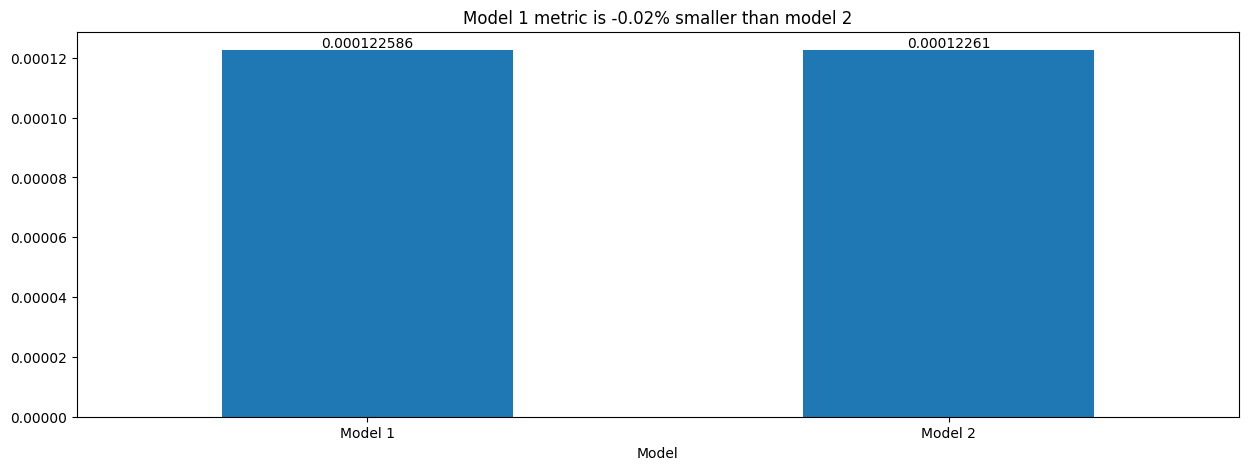

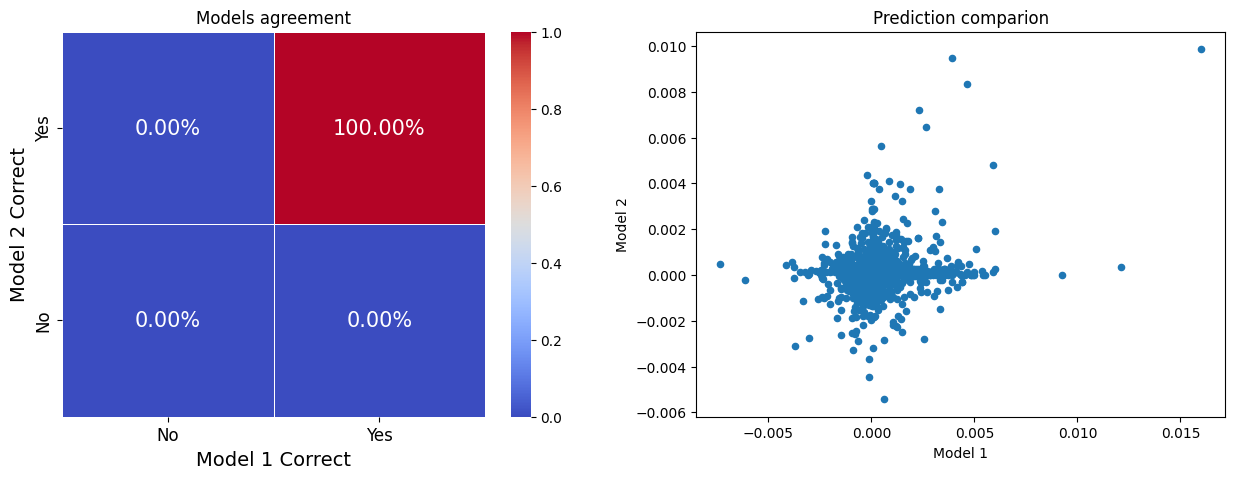

In [25]:
comparison = tml.CompareModels(data=df.tail(1800).reset_index(drop=True),
                               true_label=df.tail(1800).reset_index(drop=True)[TARGET],
                                       pred_1=oof_m[-1800:], pred_2=oof_v[-1800:],
                                       kfold=ts_folds,
                                       regression=True,
                                       probabilities=True,
                                       metric_func=mean_squared_error)
    
comparison.compare_metrics()
comparison.compare_predictions()

[8, 60, 1, 42, 30, 15, 52, 14, 6, 108]
Mean Squared Error: 0.00012
R2: 0.0044408840110623515
MAE: 0.007897589757080574
               min      mean       max
fold                                  
0     9.468564e-11  0.000110  0.001466
1     1.233985e-10  0.000060  0.000958
2     6.960286e-09  0.000322  0.001633
3     4.342013e-10  0.000078  0.001213
4     5.242882e-09  0.000102  0.000954
5     4.230355e-08  0.000246  0.001660
6     1.277681e-08  0.000078  0.000601
7     5.244882e-11  0.000054  0.000404
8     3.236655e-11  0.000069  0.000924
9     4.923460e-09  0.000115  0.001791
Sharpe: 0.8200578776140349
0 -0.13922322438928922
1 1.718594997386545
2 0.6775745394675275
3 2.779193427408948
4 0.4827288891082639
5 -0.6720534554857696
6 1.3438231870318664
7 1.679398555238386
8 1.1034127625414218
9 1.1076595607348914


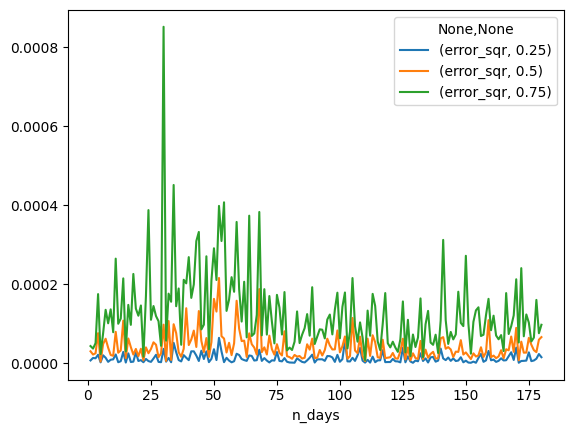

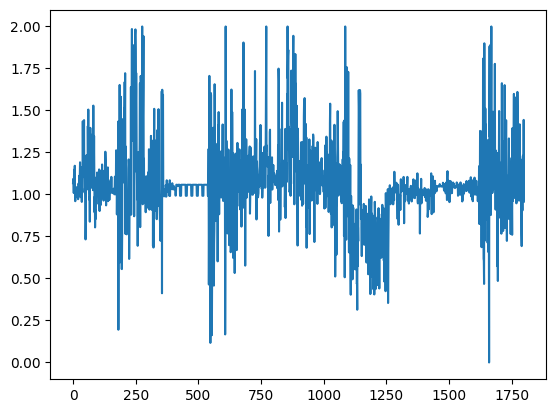

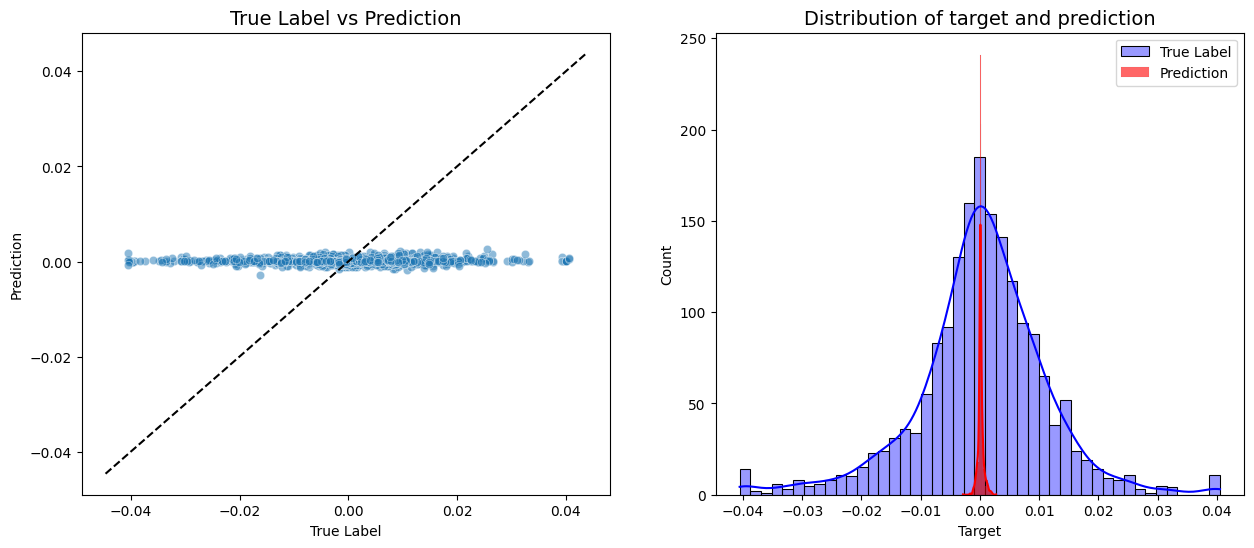

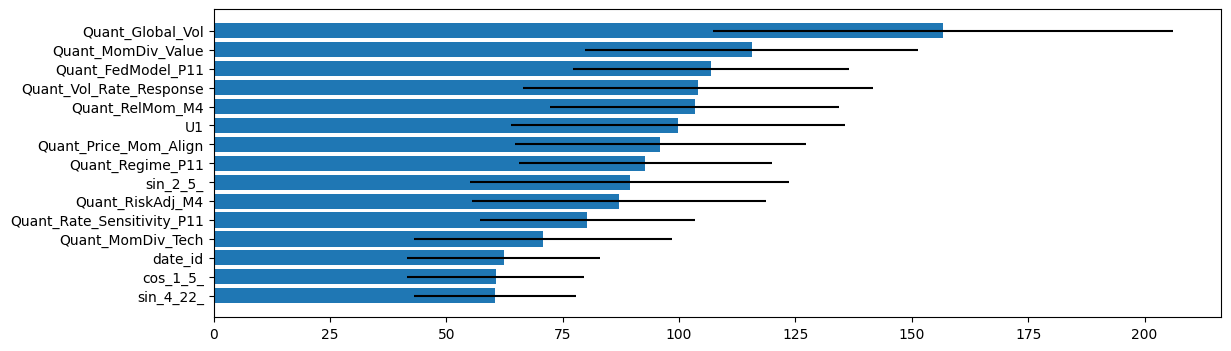

In [26]:
model = lgb.LGBMRegressor(random_state=34, n_jobs=-1, verbose=-1, n_estimators=10000,
                          learning_rate=0.01,
                          colsample_bytree=0.56,
                             min_child_weight=41,
                             reg_lambda=53.22,
                             reg_alpha=4.48,
                             subsample=0.565,
                             num_leaves=64,
                             max_depth=99)

callbacks = [lgb.early_stopping(1000, verbose=0)]
fit_params = {"callbacks":callbacks, "eval_metric": "rmse", "sample_weight": "date_id"}

processing = Pipeline([("fe", FeatureEng()),
                       ("imputer", tml.DfImputer(strategy="mean", fill_value=0)),
                       ("sel", ColumnSelector(sel_columns=["U1", "U2", 'Quant_RiskAdj_M4', 'Quant_Regime_P11', "Quant_FedModel_P11", "Quant_Global_Vol",
                "Quant_RelMom_M4", "Quant_RelMom_M1", "Quant_MomDiv_Tech", "Quant_MomDiv_Value", 
                "Quant_M4_Persistence", "Quant_M1_Persistence", "Quant_VolRegime_High", 
                "Quant_VolRegime_Low", "Quant_Price_Mom_Align", "Quant_Price_Mom_Align_Broad",
                "Quant_Rate_Sensitivity_P11", "Quant_Vol_Rate_Response"] + ["date_id"],
                patterns=[("cos", "contains"), ("sin", "contains")]))
                       #("scaler", tml.DfScaler())
                            ])

pipe = Pipeline([("processing", processing),
                ("model", model)])

train = make_lags_train(df)

FEATURES = [c for c in train.columns if c not in DROP]

cvscore = TSCrossValidate(data=train[FEATURES], target=train[TARGET], cv=ts_folds, estimator=pipe, shap=False, imp_coef=True, fit_params=fit_params, early_stopping=True)
oof_feats, res = cvscore.score()

pos_feats = np.clip(oof_feats * 865 + 1, 0, 2)

print(res["iterations"])

summary_evaluation(res["folds_eval"], df, factor=507)

tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="standard")

# to_plot = res["feat_imp"].head(6)["Feature"].to_list()
# tml.plot_shap_values(res["shap_values"], features=to_plot)

[48, 35, 3, 28, 488, 4, 107, 79, 11, 770]
Mean Squared Error: 0.00012
R2: 0.00972109054843917
MAE: 0.007917034133531859
               min      mean       max
fold                                  
0     6.290344e-12  0.000110  0.001404
1     1.161193e-09  0.000061  0.000972
2     5.289002e-11  0.000321  0.001633
3     3.254793e-08  0.000079  0.001170
4     1.970588e-13  0.000096  0.000829
5     2.305906e-09  0.000246  0.001648
6     1.745634e-10  0.000078  0.000596
7     5.917147e-10  0.000054  0.000393
8     2.148794e-10  0.000069  0.000928
9     7.477002e-09  0.000113  0.002299
Sharpe: 1.0088664644715069
0 0.04500237960744765
1 1.4595499046087421
2 0.8138981212468749
3 2.7656013807264923
4 1.7875814523226845
5 -0.660637187856616
6 1.8131986962874058
7 2.002816395026746
8 1.1825727094249991
9 1.2672384234194576


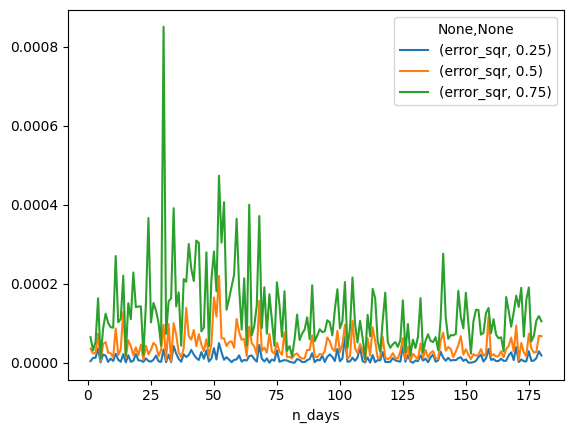

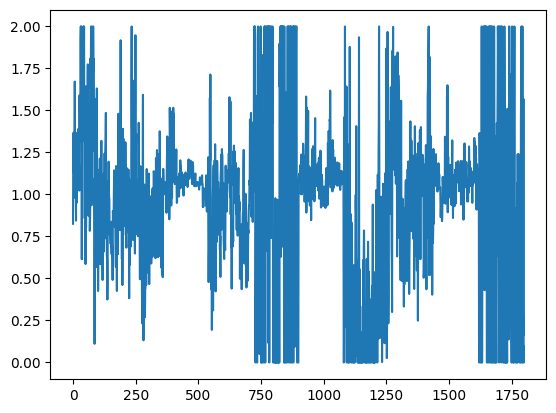

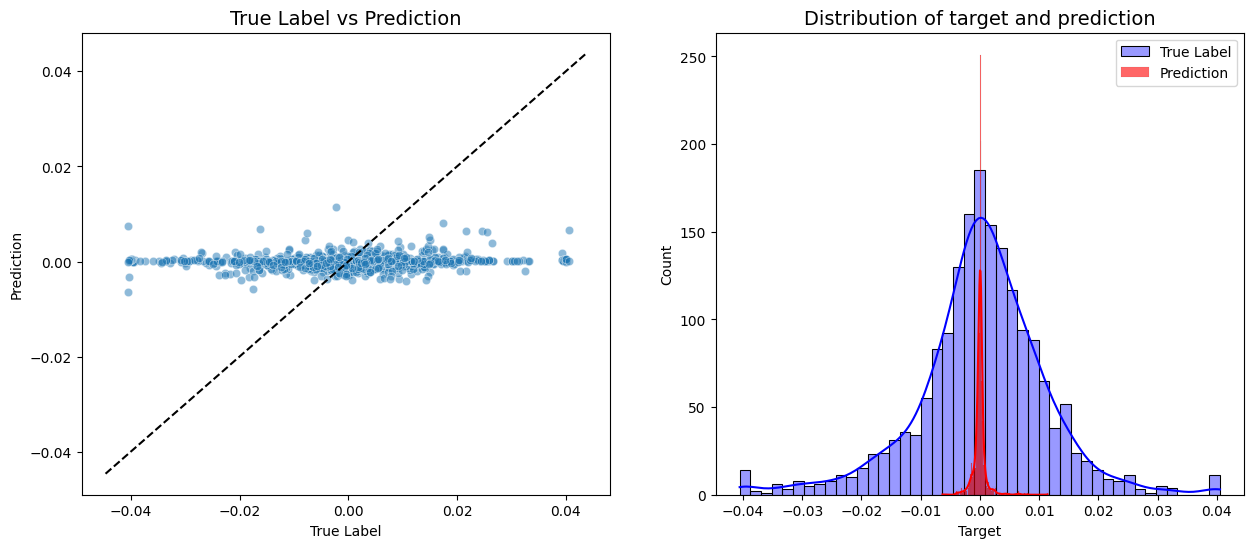

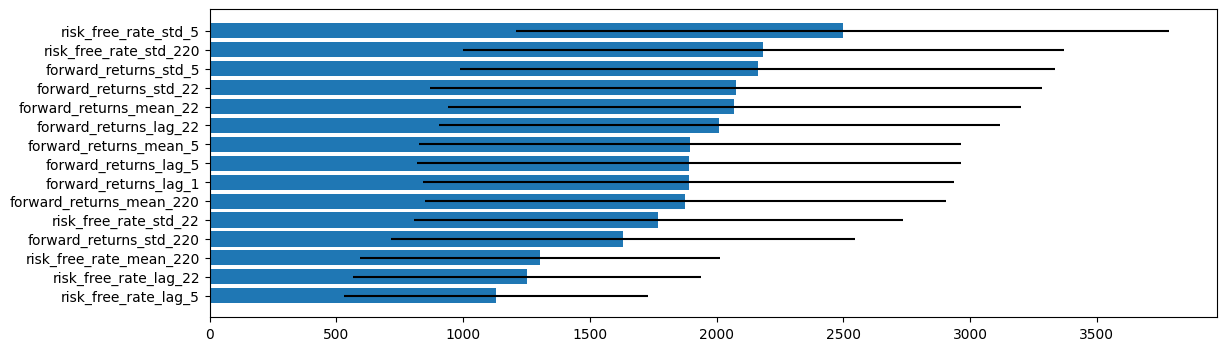

In [27]:
model = lgb.LGBMRegressor(random_state=34, n_jobs=-1, verbose=-1, n_estimators=10000,
                          learning_rate=0.01,
                          colsample_bytree=0.358,
                             min_child_weight=218.57,
                             reg_lambda=13.25,
                             reg_alpha=18.46,
                             subsample=0.413,
                             num_leaves=199,
                             max_depth=200)

callbacks = [lgb.early_stopping(1000, verbose=0)]
fit_params = {"callbacks":callbacks, "eval_metric": "rmse", "sample_weight": "date_id"}

processing = Pipeline([("fe", FeatureEng()),
                       ("imputer", tml.DfImputer(strategy="median", fill_value=0)),
                       ("sel", ColumnSelector(patterns=[("lag", "contains"), ("streak", "contains"), ("_mean_", "contains"), ("_std_", "contains")]))
                       #("scaler", tml.DfScaler())
                            ])

pipe = Pipeline([("processing", processing),
                ("model", model)])

train = make_lags_train(df)

FEATURES = [c for c in train.columns if c not in DROP]

cvscore = TSCrossValidate(data=train[FEATURES], target=train[TARGET], cv=ts_folds, estimator=pipe, shap=False, imp_coef=True, fit_params=fit_params, early_stopping=True)
oof_lags, res = cvscore.score()

pos_lags = np.clip(oof_lags * 898 + 1, 0, 2)

print(res["iterations"])

summary_evaluation(res["folds_eval"], df, factor=898)

tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="standard")

# to_plot = res["feat_imp"].head(6)["Feature"].to_list()
# tml.plot_shap_values(res["shap_values"], features=to_plot)

In [28]:
all_pos = pd.DataFrame()

#all_pos["pos_d"] = pos_d
#all_pos["pos_e"] = pos_e
#all_pos["pos_feats"] = pos_feats
#all_pos["pos_i"] = pos_i
all_pos["pos_lags"] = pos_lags
#all_pos["pos_m"] = pos_m
all_pos["pos_p"] = pos_p
#all_pos["pos_s"] = pos_s
all_pos["pos_v"] = pos_v

all_pos["mean_pos"] = all_pos.mean(axis=1)


all_pos

pos_lags     pos_p     pos_v  mean_pos
0          NaN       NaN       NaN       NaN
1          NaN       NaN       NaN       NaN
2          NaN       NaN       NaN       NaN
3          NaN       NaN       NaN       NaN
4          NaN       NaN       NaN       NaN
...        ...       ...       ...       ...
8015  0.354066  0.654070  1.114134  0.707423
8016  0.160970  0.358688  1.025064  0.514907
8017  1.568880  0.000000  1.114134  0.894338
8018  0.000000  0.000000  1.114134  0.371378
8019  0.093646  0.000000  1.114134  0.402593

[8020 rows x 4 columns]

In [29]:
all_pos.corr()

pos_lags     pos_p     pos_v  mean_pos
pos_lags  1.000000  0.076888  0.065445  0.650194
pos_p     0.076888  1.000000  0.019633  0.627451
pos_v     0.065445  0.019633  1.000000  0.541665
mean_pos  0.650194  0.627451  0.541665  1.000000

In [30]:
res["folds_eval"]["prediction"] = all_pos["mean_pos"].dropna().reset_index(drop=True)

print(f"Sharpe: {score_sharpe(solution=df[df["date_id"] >= res["folds_eval"]["date_id"].min()].reset_index(drop=True),
                                  submission=res["folds_eval"], row_id_column_name='')}")
for n, group in res["folds_eval"].groupby("fold"):
    print(n, score_sharpe(solution=df[(df["date_id"] >= group["date_id"].min()) &
                                            (df["date_id"] <= group["date_id"].max())].reset_index(drop=True).copy(),
                            submission=group.reset_index(), row_id_column_name=""))

Sharpe: 1.0943274158459462
0 -0.020688779389082958
1 2.4773975096938323
2 0.820150455552627
3 2.6785474631047266
4 1.8712236152357777
5 -0.5731976318009402
6 1.8572936169021184
7 2.3240489229728887
8 1.4138582263361739
9 1.2844748321867387


[3, 40, 1, 3, 24, 41, 5, 12, 122, 16]
Mean Squared Error: 0.00012
R2: 0.006246637511352238
MAE: 0.007905738069781261
               min      mean       max
fold                                  
0     6.363448e-10  0.000110  0.001531
1     1.134629e-09  0.000059  0.000955
2     1.664789e-10  0.000322  0.001633
3     5.823726e-10  0.000079  0.001200
4     1.420605e-09  0.000102  0.000976
5     2.903704e-08  0.000242  0.001657
6     4.424042e-09  0.000078  0.000608
7     2.047648e-10  0.000054  0.000404
8     2.231624e-11  0.000069  0.000916
9     1.651314e-09  0.000115  0.001735
Sharpe: 0.9925641572934224
0 -0.044255380168502764
1 1.6263606408927531
2 0.5258309519259351
3 2.484453936821102
4 0.538077979754721
5 0.6126620631289793
6 1.3210019027686615
7 1.6567722863219716
8 1.264142115180704
9 1.100637010722263


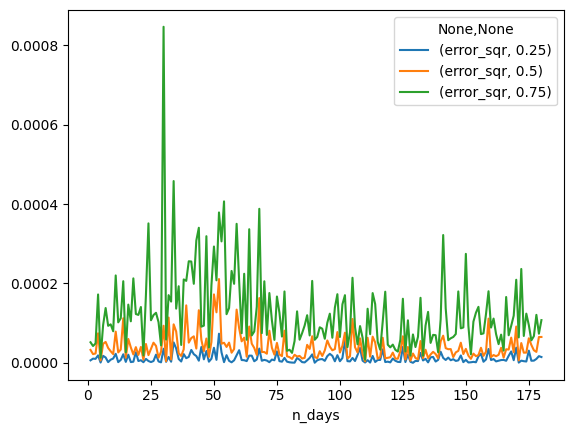

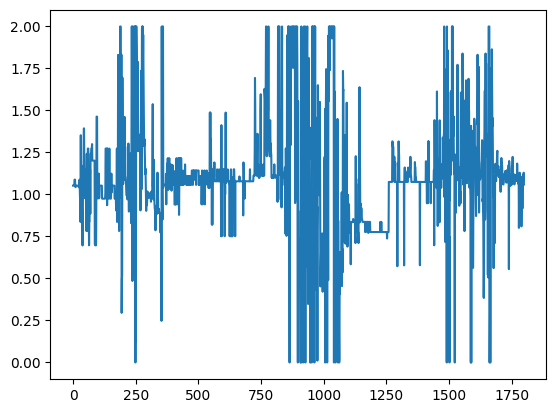

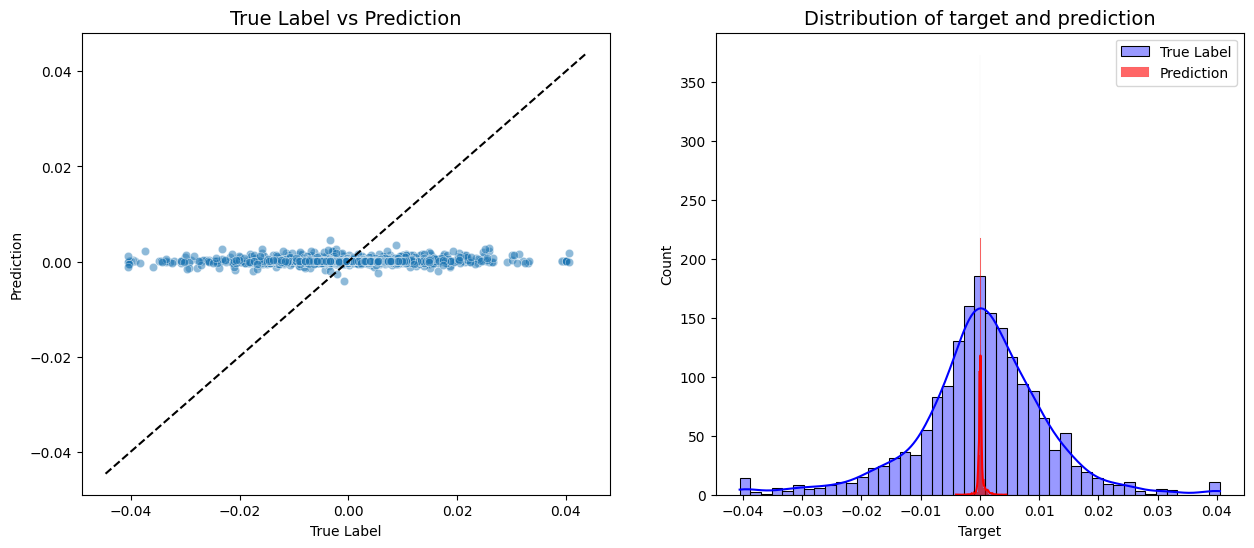

In [31]:
model = lgb.LGBMRegressor(random_state=34, n_jobs=-1, verbose=-1, n_estimators=10000,
                          learning_rate=0.01,
                          colsample_bytree=0.95,
                             min_child_weight=299,
                             reg_lambda=58,
                             reg_alpha=38,
                             subsample=0.788,
                             num_leaves=67,
                             max_depth=127)

callbacks = [lgb.early_stopping(1000, verbose=0)]
fit_params = {"callbacks":callbacks, "eval_metric": "rmse", "sample_weight": "date_id"}

processing = Pipeline([("fe", FeatureEng(u1=True, u2=True, add_ts=False,
                                             riskadj_m4=False, quant_p11=False, fed_model=False,
                                             glob_vol=False, relmom=True, mom_div=False,
                                             mompersistence=False, momregime=False, vol_spread=True,
                                             price_mom=True, rate_sens=False)),
                            ("imputer", tml.DfImputer(strategy="constant", fill_value=0)),
                            #("scaler", tml.DfScaler())
                            ])

pipe = Pipeline([("processing", processing),
                ("model", model)])

train = make_lags_train(df)

FEATURES = [c for c in train.columns if c not in DROP]

cvscore = TSCrossValidate(data=train[FEATURES], target=train[TARGET], cv=ts_folds, estimator=pipe, shap=False, imp_coef=True, fit_params=fit_params, early_stopping=True)
oof_tot, res = cvscore.score()

pos_tot = np.clip(oof_tot * 970 + 1, 0, 2)

print(res["iterations"])

summary_evaluation(res["folds_eval"], df, factor=970)

In [32]:
all_pos = pd.DataFrame()

#all_pos["pos_d"] = pos_d
#all_pos["pos_e"] = pos_e
#all_pos["pos_feats"] = pos_feats
#all_pos["pos_i"] = pos_i
all_pos["pos_lags"] = pos_lags
#all_pos["pos_m"] = pos_m
all_pos["pos_p"] = pos_p
#all_pos["pos_s"] = pos_s
all_pos["pos_v"] = pos_v
all_pos["pos_tot"] = pos_tot

all_pos["mean_pos"] = all_pos.mean(axis=1)

all_pos.corr()

pos_lags     pos_p     pos_v   pos_tot  mean_pos
pos_lags  1.000000  0.076888  0.065445  0.191246  0.620510
pos_p     0.076888  1.000000  0.019633  0.172380  0.594636
pos_v     0.065445  0.019633  1.000000  0.111249  0.500471
pos_tot   0.191246  0.172380  0.111249  1.000000  0.567394
mean_pos  0.620510  0.594636  0.500471  0.567394  1.000000

In [33]:
res["folds_eval"]["prediction"] = all_pos["mean_pos"].dropna().reset_index(drop=True)

print(f"Sharpe: {score_sharpe(solution=df[df["date_id"] >= res["folds_eval"]["date_id"].min()].reset_index(drop=True),
                                  submission=res["folds_eval"], row_id_column_name='')}")
for n, group in res["folds_eval"].groupby("fold"):
    print(n, score_sharpe(solution=df[(df["date_id"] >= group["date_id"].min()) &
                                            (df["date_id"] <= group["date_id"].max())].reset_index(drop=True).copy(),
                            submission=group.reset_index(), row_id_column_name=""))

Sharpe: 1.0919133565779202
0 -0.02494800523456878
1 2.374541533037159
2 0.7491870147578396
3 2.6450437132560087
4 1.4664498767009568
5 -0.23666903457465197
6 1.7482415819787112
7 2.160117675871336
8 1.4259707101821388
9 1.2833963419004502


<Axes: >

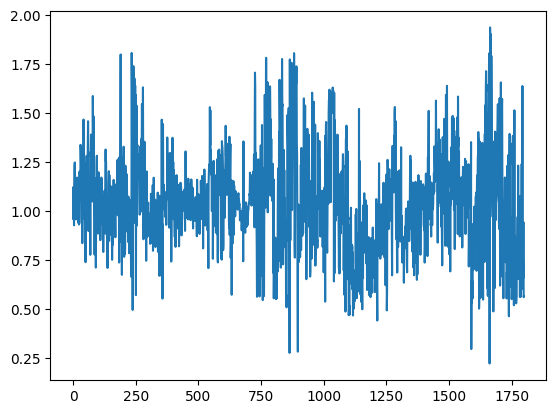

In [34]:
res["folds_eval"]["prediction"].plot()

[3, 254, 4, 18, 13, 24, 24, 80, 97, 38]
Mean Squared Error: 0.00012
R2: 0.003325687582406478
MAE: 0.007914618312811384
               min      mean       max
fold                                  
0     1.070698e-10  0.000110  0.001508
1     2.620195e-10  0.000061  0.000962
2     2.787583e-10  0.000322  0.001647
3     8.264498e-09  0.000078  0.001246
4     1.503513e-12  0.000102  0.000921
5     5.386885e-08  0.000246  0.001687
6     3.606796e-09  0.000078  0.000585
7     6.441151e-15  0.000054  0.000404
8     6.821200e-09  0.000069  0.000975
9     3.476681e-10  0.000116  0.001663
Sharpe: 0.7833813922380283
0 -0.040651454350445475
1 1.2226365148684823
2 0.6146674868432536
3 2.5674843391305293
4 0.700378653299839
5 -0.649663057306381
6 1.8747497172290164
7 2.3054928825296126
8 1.0345970964609212
9 1.1498980860042685


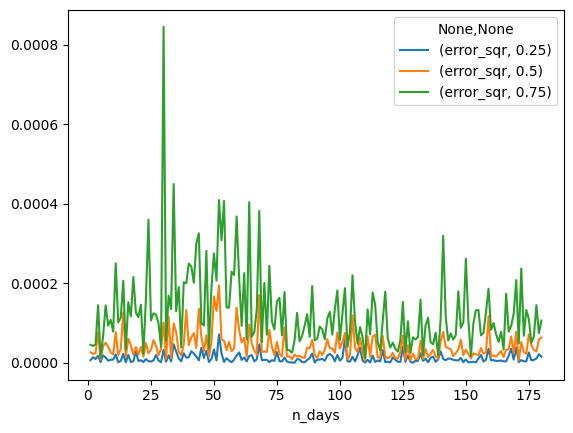

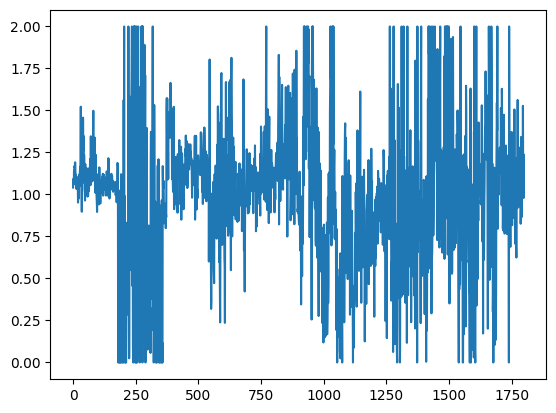

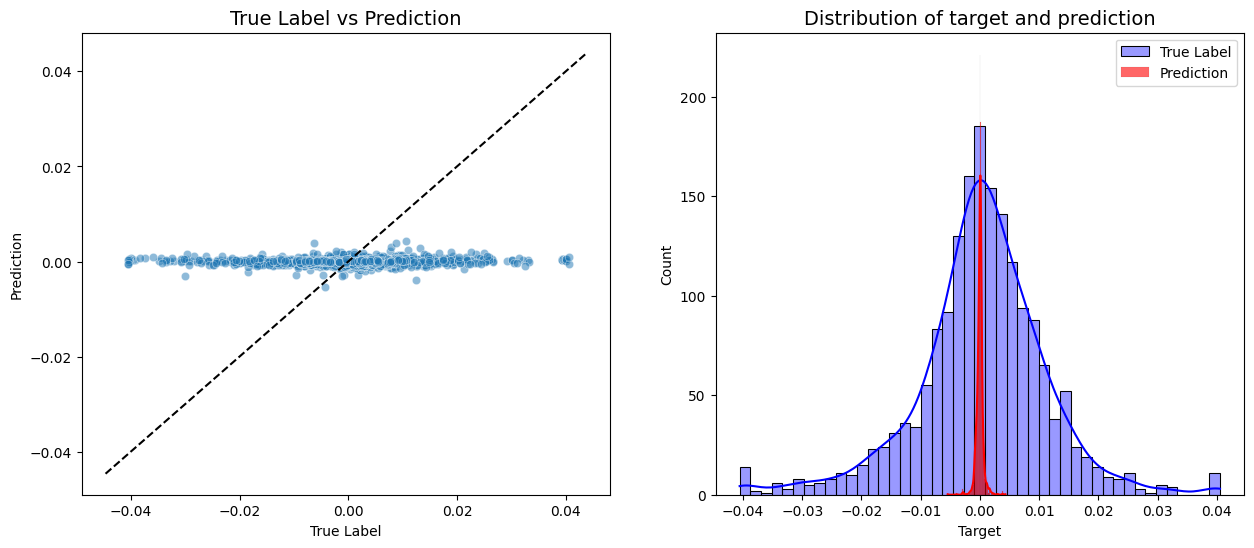

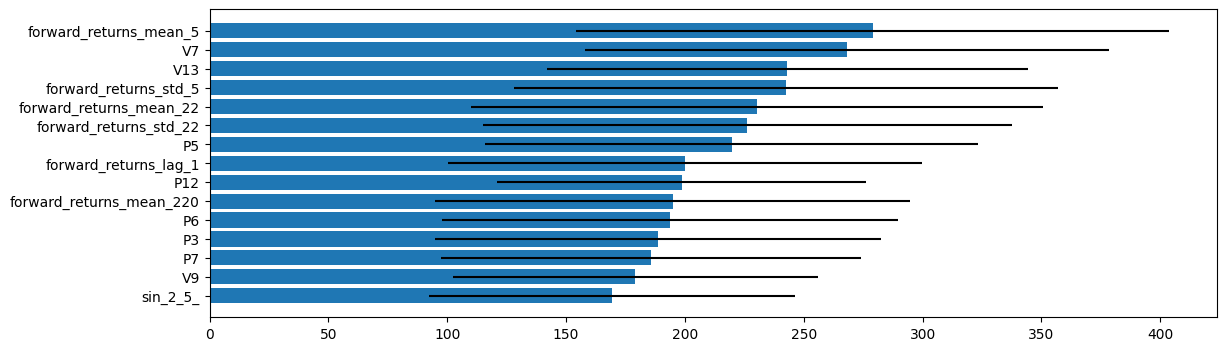

In [40]:
model = lgb.LGBMRegressor(random_state=34, n_jobs=-1, verbose=-1, n_estimators=10000,
                          learning_rate=0.01,
                          colsample_bytree=0.476,
                             min_child_weight=131.7,
                             reg_lambda=27.9,
                             reg_alpha=29.9,
                             subsample=0.95,
                             num_leaves=143,
                             max_depth=82)

callbacks = [lgb.early_stopping(1000, verbose=0)]
fit_params = {"callbacks":callbacks, "eval_metric": "rmse", "sample_weight": "date_id"}

processing = Pipeline([("fe", FeatureEng()),
                       ("imputer", tml.DfImputer(strategy="constant", fill_value=0)),
                       ("sel", ColumnSelector(patterns=[("lag", "contains"),
                                                        ("streak", "contains"),
                                                        ("_mean_", "contains"),
                                                        ("_std_", "contains"),
                                                        ("sin", "contains"),
                                                        ("cos", "contains"),
                                                        ("P", "startswith"),
                                                        ("U", "startswith"),
                                                        ("V", "startswith")]))
                       #("scaler", tml.DfScaler())
                            ])

pipe = Pipeline([("processing", processing),
                ("model", model)])

train = make_lags_train(df)

FEATURES = [c for c in train.columns if c not in DROP]

cvscore = TSCrossValidate(data=train[FEATURES], target=train[TARGET], cv=ts_folds, estimator=pipe, shap=False, imp_coef=True, fit_params=fit_params, early_stopping=True)
oof_fancy, res = cvscore.score()

pos_fancy = np.clip(oof_fancy * 1000 + 1, 0, 2)

print(res["iterations"])

summary_evaluation(res["folds_eval"], df, factor=1000)

tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="standard")

# to_plot = res["feat_imp"].head(6)["Feature"].to_list()
# tml.plot_shap_values(res["shap_values"], features=to_plot)

In [41]:
all_pos = pd.DataFrame()

#all_pos["pos_d"] = pos_d
#all_pos["pos_e"] = pos_e
#all_pos["pos_feats"] = pos_feats
#all_pos["pos_i"] = pos_i
all_pos["pos_lags"] = pos_lags
#all_pos["pos_m"] = pos_m
all_pos["pos_p"] = pos_p
#all_pos["pos_s"] = pos_s
all_pos["pos_v"] = pos_v
all_pos["pos_fancy"] = pos_fancy

all_pos["mean_pos"] = all_pos.mean(axis=1)

all_pos.corr()

pos_lags     pos_p     pos_v  pos_fancy  mean_pos
pos_lags   1.000000  0.076888  0.065445   0.179665  0.608632
pos_p      0.076888  1.000000  0.019633   0.076126  0.547492
pos_v      0.065445  0.019633  1.000000   0.168627  0.514806
pos_fancy  0.179665  0.076126  0.168627   1.000000  0.598911
mean_pos   0.608632  0.547492  0.514806   0.598911  1.000000

In [42]:
res["folds_eval"]["prediction"] = all_pos["mean_pos"].dropna().reset_index(drop=True)

print(f"Sharpe: {score_sharpe(solution=df[df["date_id"] >= res["folds_eval"]["date_id"].min()].reset_index(drop=True),
                                  submission=res["folds_eval"], row_id_column_name='')}")
for n, group in res["folds_eval"].groupby("fold"):
    print(n, score_sharpe(solution=df[(df["date_id"] >= group["date_id"].min()) &
                                            (df["date_id"] <= group["date_id"].max())].reset_index(drop=True).copy(),
                            submission=group.reset_index(), row_id_column_name=""))

Sharpe: 1.0323309300498005
0 -0.02520234939330434
1 2.2884636155863487
2 0.7776956120540389
3 2.690282764389555
4 1.5998226067473875
5 -0.6251940559623214
6 1.9066737353799064
7 2.3834763554125113
8 1.3513903322008292
9 1.2656450456190682


<Axes: >

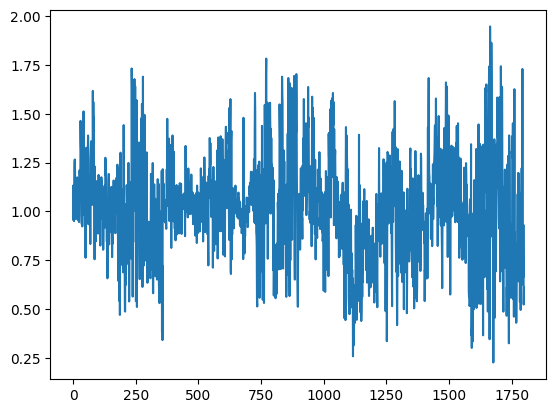

In [43]:
res["folds_eval"]["prediction"].plot()